###Project 5 - Kevin Krupinski

Inclusion Section

In [1]:
import numpy as np
import cv2
import glob
import random

import os
from os.path import basename

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from moviepy.editor import VideoFileClip

from scipy.ndimage.measurements import label
from scipy.ndimage.measurements import label

from skimage.feature import hog

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

In [2]:
# misc setup
random.seed()

## Lesson Functions

In [3]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [4]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [5]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [6]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [7]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bounding_boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bounding_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, bounding_boxes

In [8]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

In [9]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [10]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


In [11]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [12]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orientation=9,px_per_cell=32, cells_per_block=2):
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for image in imgs:
        # Read in each one by one
        # image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        
        ## Feature Extraction Methods ##
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Apply hog_features() 
        hog_features = []
        for cur_ch in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,cur_ch],orientation,px_per_cell,cells_per_block,
                                                 vis=False,feature_vec=True))
        hog_features = np.ravel(hog_features)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    # Return list of feature vectors
    return features

In [13]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img_in, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):   
    
    
    #1) Define an empty list to receive features
    features = []
    #drawme = True
    
    for cur_img in img_in:
        img_features = []
        img = mpimg.imread(cur_img)
        
        #2) Apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)    
        
        #3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            #4) Append features to list
            img_features.append(spatial_features)
            
        #5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            #6) Append features to list
            img_features.append(hist_features)
            
        #7) Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))   
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
            #8) Append features to list
            
            img_features.append(hog_features)
        features.append(np.concatenate(img_features))
        
        #if drawme:
            #f, (ax1,ax2, ax3) = plt.subplots(1,3,figsize=(20,5))
            #ax1.set_title('Ori')
            #ax1.imshow(img)
            #ax2.set_title('Spatial Hist')
            #ax2.plot(range(len(spatial_features)), spatial_features,color='r')
            #ax3.set_title('Color Hist')
            #ax3.plot(range(len(hist_features)),hist_features)
            #plt.show()
            #drawme = False
            #return features
    
    #9) Return concatenated array of features
    return features

In [14]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=(None, None), y_start_stop=(None, None), 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop = (0, x_start_stop[1])
    if x_start_stop[1] == None:
        x_start_stop = (x_start_stop[0], img.shape[1])
    if y_start_stop[0] == None:
        y_start_stop = (0, y_start_stop[1])
    if y_start_stop[1] == None:
        y_start_stop = (y_start_stop[0], img.shape[0])
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    xstep = int(xy_window[0] * (1-xy_overlap[0]))
    ystep = int(xy_window[1] * (1-xy_overlap[1]))
    
    
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    
    # Compute the number of windows in x/y
    xwinds = int((xspan-nx_buffer) / xstep)
    ywinds = int((yspan-ny_buffer) / ystep)
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for x in range(xwinds):
        for y in range(ywinds):
            #     Note: you could vectorize this step, but in practice
            #     you'll be considering windows one by one with your
            #     classifier, so looping makes sense
            # Calculate each window position
            xpos = x * xstep + x_start_stop[0]
            ypos = y * ystep + y_start_stop[0]
            # Append window position to list
            window_list.append(((xpos,ypos),(xpos+xy_window[0],ypos+xy_window[1])))
    # Return the list of windows
    return window_list

In [15]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

## Data Load

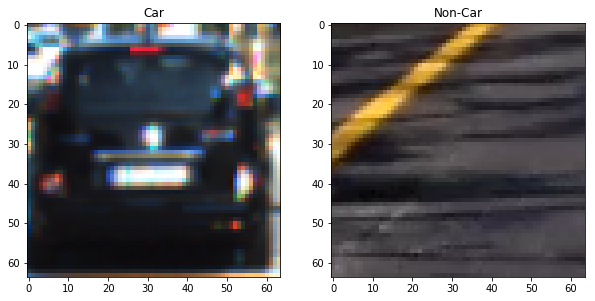

In [16]:
valid = []
invalid = []
for img in glob.glob('./dataset/vehicles/*.png'):
    valid.append(img)
    
for img in glob.glob('./dataset/non_vehicles/*.png'):
    invalid.append(img)
    
# Test plot to validate loading
f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.set_title('Car')
ax1.imshow(mpimg.imread(valid[random.randint(0,len(valid)-1)]))
ax2.set_title('Non-Car')
ax2.imshow(mpimg.imread(invalid[random.randint(0,len(invalid)-1)]))

## Extraction Params

In [17]:
param_cspace = 'YCrCb'
param_spatial_size = (8,8)
param_hist_bins =16
param_hist_range=(0, 256)
param_px_per_cell = 8
param_orientation = 9
param_cells_per_block = 2
param_HOG_channel = 'ALL'
param_spatial_feat = True
param_hist_feat = True
param_HOG_feat = True

## Feature Extraction -- Long Run Time -- Beware

In [18]:
features_vehicles = single_img_features(valid,color_space=param_cspace,spatial_size=param_spatial_size,
                                        hist_bins=param_hist_bins,orient=param_orientation,pix_per_cell=param_px_per_cell,
                                        cell_per_block=param_cells_per_block,hog_channel=param_HOG_channel,
                                        spatial_feat=param_spatial_feat,hist_feat=param_hist_feat,hog_feat=param_HOG_feat)

In [19]:
features_nonvehicles = single_img_features(invalid,color_space=param_cspace,spatial_size=param_spatial_size, 
                                        hist_bins=param_hist_bins,orient=param_orientation,pix_per_cell=param_px_per_cell,
                                        cell_per_block=param_cells_per_block,hog_channel=param_HOG_channel,
                                        spatial_feat=param_spatial_feat,hist_feat=param_hist_feat,hog_feat=param_HOG_feat)

## Build Training / Test Sets

In [20]:
print(np.shape(features_vehicles))
print(np.shape(features_nonvehicles))

# Scale features
combined_features = np.vstack((features_vehicles,features_nonvehicles)).astype(np.float64)
feature_scaler = StandardScaler().fit(combined_features)
combined_features_scaled = feature_scaler.transform(combined_features)

# Build Labels (1=vehicle, 0=non-veh)
combined_features_labels = np.hstack((np.ones(len(features_vehicles)),np.zeros(len(features_nonvehicles))))

# Split Training / Test
X_train, X_test, y_train, y_test = train_test_split(combined_features_scaled, combined_features_labels, test_size=0.2)
print('Training Set Length:',len(X_train))
print('Test Set Length:',len(X_test))


(5679, 5532)

(8968, 5532)

Training Set Length:

11717

Test Set Length:

2930

## SVC Classifier

In [21]:
svc = LinearSVC()
svc.fit(X_train,y_train)
print('Accuracy:',svc.score(X_test,y_test))

Accuracy:

0.990102389078

##Singular Image Testing

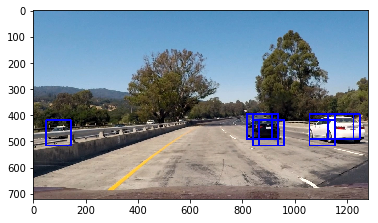

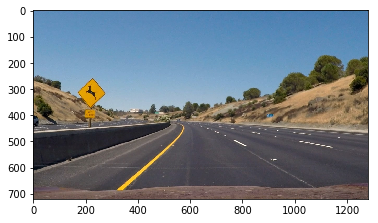

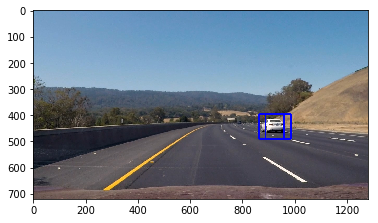

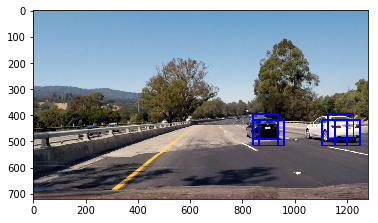

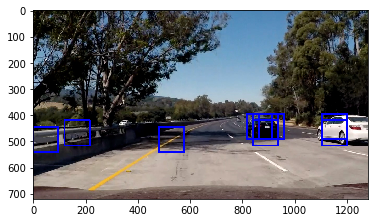

In [22]:
test_images = glob.glob('./test_images/test*.jpg')

for img in test_images:
    img_in = mpimg.imread(img)
    img_processed,boxes = find_cars(img_in,int(np.floor(img_in.shape[0]*0.55)),int(np.ceil(img_in.shape[0]*0.90)),
                              1.5,svc,feature_scaler,param_orientation,param_px_per_cell,param_cells_per_block,param_spatial_size,param_hist_bins)
    plt.figure()
    plt.imshow(img_processed)
    

## Define Complete Pipeline

In [23]:
def Vehicle_Finder(img):
    global allBoxes
    global ID
    ID += 1
    boxlist = []
    
    # find current frame bounding boxes
    img_out, curBoxes = find_cars(img,int(np.floor(img.shape[0]*0.55)),int(np.ceil(img.shape[0]*0.90)),
                                  1.5,svc,feature_scaler,param_orientation,param_px_per_cell,param_cells_per_block,
                                  param_spatial_size,param_hist_bins)
    
    # Append to running list
    allBoxes.append(curBoxes)
    allBoxes = allBoxes[-10:]
    
    # Generate heatmap
    hmap = np.zeros_like(img[:,:,0])
    for cycleBox in allBoxes:
        for curBox in cycleBox:
            boxlist.append(curBox)
    
    hmap = add_heat(hmap,boxlist)
    hmap = apply_threshold(hmap,5)
    hmap = np.clip(hmap, 0, 255)
    labels = label(hmap)
    
    final_frame = draw_labeled_bboxes(np.copy(img),labels)
    
    mpimg.imsave("Img_%d.png" % ID,final_frame)
    #mpimg.imsave("Label_%d.png" % ID,labels,plt.cm.gray)
    mpimg.imsave("Heatmap_%d.png" % ID,hmap,cmap=plt.cm.jet,vmin=0,vmax=10)
    
    return final_frame

## Video Test

In [25]:
allBoxes = []
ID = 0
project_output_file = "project_output.mp4"
#project_video = VideoFileClip("./test_video.mp4")
project_video = VideoFileClip("./project_video.mp4")
#project_output = project_video.fl_image(LineFinder)
project_output = project_video.fl_image(Vehicle_Finder)
%time project_output.write_videofile(project_output_file, audio=False)

[MoviePy] >>>> Building video project_output_final.mp4


[MoviePy] Writing video project_output_final.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<14:18,  1.47it/s]

  0%|          | 2/1261 [00:01<14:14,  1.47it/s]

  0%|          | 3/1261 [00:02<14:06,  1.49it/s]

  0%|          | 4/1261 [00:02<13:59,  1.50it/s]

  0%|          | 5/1261 [00:03<14:06,  1.48it/s]

  0%|          | 6/1261 [00:03<13:53,  1.51it/s]

  1%|          | 7/1261 [00:04<13:32,  1.54it/s]

  1%|          | 8/1261 [00:05<13:16,  1.57it/s]

  1%|          | 9/1261 [00:05<13:06,  1.59it/s]

  1%|          | 10/1261 [00:06<12:49,  1.63it/s]

  1%|          | 11/1261 [00:06<12:29,  1.67it/s]

  1%|          | 12/1261 [00:07<12:13,  1.70it/s]

  1%|          | 13/1261 [00:08<12:02,  1.73it/s]

  1%|          | 14/1261 [00:08<12:03,  1.72it/s]

  1%|          | 15/1261 [00:09<12:07,  1.71it/s]

  1%|▏         | 16/1261 [00:09<12:02,  1.72it/s]

  1%|▏         | 17/1261 [00:10<12:27,  1.66it/s]

  1%|▏         | 18/1261 [00:11<13:14,  1.56it/s]

  2%|▏         | 19/1261 [00:11<13:00,  1.59it/s]

  2%|▏         | 20/1261 [00:12<12:49,  1.61it/s]

  2%|▏         | 21/1261 [00:12<12:30,  1.65it/s]

  2%|▏         | 22/1261 [00:13<12:21,  1.67it/s]

  2%|▏         | 23/1261 [00:14<12:10,  1.69it/s]

  2%|▏         | 24/1261 [00:14<12:11,  1.69it/s]

  2%|▏         | 25/1261 [00:15<12:18,  1.67it/s]

  2%|▏         | 26/1261 [00:15<12:08,  1.69it/s]

  2%|▏         | 27/1261 [00:16<12:12,  1.68it/s]

  2%|▏         | 28/1261 [00:17<12:49,  1.60it/s]

  2%|▏         | 29/1261 [00:17<13:33,  1.51it/s]

  2%|▏         | 30/1261 [00:18<13:05,  1.57it/s]

  2%|▏         | 31/1261 [00:19<13:01,  1.57it/s]

  3%|▎         | 32/1261 [00:19<12:46,  1.60it/s]

  3%|▎         | 33/1261 [00:20<12:23,  1.65it/s]

  3%|▎         | 34/1261 [00:20<12:09,  1.68it/s]

  3%|▎         | 35/1261 [00:21<11:55,  1.71it/s]

  3%|▎         | 36/1261 [00:22<11:45,  1.74it/s]

  3%|▎         | 37/1261 [00:22<11:38,  1.75it/s]

  3%|▎         | 38/1261 [00:23<11:35,  1.76it/s]

  3%|▎         | 39/1261 [00:23<11:36,  1.75it/s]

  3%|▎         | 40/1261 [00:24<11:34,  1.76it/s]

  3%|▎         | 41/1261 [00:24<11:30,  1.77it/s]

  3%|▎         | 42/1261 [00:25<11:27,  1.77it/s]

  3%|▎         | 43/1261 [00:25<11:25,  1.78it/s]

  3%|▎         | 44/1261 [00:26<11:29,  1.77it/s]

  4%|▎         | 45/1261 [00:27<11:29,  1.76it/s]

  4%|▎         | 46/1261 [00:27<11:29,  1.76it/s]

  4%|▎         | 47/1261 [00:28<11:26,  1.77it/s]

  4%|▍         | 48/1261 [00:28<11:25,  1.77it/s]

  4%|▍         | 49/1261 [00:29<11:31,  1.75it/s]

  4%|▍         | 50/1261 [00:29<11:30,  1.75it/s]

  4%|▍         | 51/1261 [00:30<11:31,  1.75it/s]

  4%|▍         | 52/1261 [00:31<11:28,  1.76it/s]

  4%|▍         | 53/1261 [00:31<11:25,  1.76it/s]

  4%|▍         | 54/1261 [00:32<11:24,  1.76it/s]

  4%|▍         | 55/1261 [00:32<11:26,  1.76it/s]

  4%|▍         | 56/1261 [00:33<11:24,  1.76it/s]

  5%|▍         | 57/1261 [00:33<11:23,  1.76it/s]

  5%|▍         | 58/1261 [00:34<11:21,  1.76it/s]

  5%|▍         | 59/1261 [00:35<11:34,  1.73it/s]

  5%|▍         | 60/1261 [00:35<11:50,  1.69it/s]

  5%|▍         | 61/1261 [00:36<11:55,  1.68it/s]

  5%|▍         | 62/1261 [00:36<11:44,  1.70it/s]

  5%|▍         | 63/1261 [00:37<11:48,  1.69it/s]

  5%|▌         | 64/1261 [00:38<12:00,  1.66it/s]

  5%|▌         | 65/1261 [00:38<12:30,  1.59it/s]

  5%|▌         | 66/1261 [00:39<12:20,  1.61it/s]

  5%|▌         | 67/1261 [00:40<14:20,  1.39it/s]

  5%|▌         | 68/1261 [00:41<14:17,  1.39it/s]

  5%|▌         | 69/1261 [00:41<14:33,  1.36it/s]

  6%|▌         | 70/1261 [00:42<13:45,  1.44it/s]

  6%|▌         | 71/1261 [00:43<13:09,  1.51it/s]

  6%|▌         | 72/1261 [00:43<12:45,  1.55it/s]

  6%|▌         | 73/1261 [00:44<12:30,  1.58it/s]

  6%|▌         | 74/1261 [00:44<12:36,  1.57it/s]

  6%|▌         | 75/1261 [00:45<13:13,  1.49it/s]

  6%|▌         | 76/1261 [00:46<13:00,  1.52it/s]

  6%|▌         | 77/1261 [00:46<12:44,  1.55it/s]

  6%|▌         | 78/1261 [00:47<12:51,  1.53it/s]

  6%|▋         | 79/1261 [00:48<12:58,  1.52it/s]

  6%|▋         | 80/1261 [00:48<12:42,  1.55it/s]

  6%|▋         | 81/1261 [00:49<12:18,  1.60it/s]

  7%|▋         | 82/1261 [00:50<12:30,  1.57it/s]

  7%|▋         | 83/1261 [00:50<12:25,  1.58it/s]

  7%|▋         | 84/1261 [00:51<12:19,  1.59it/s]

  7%|▋         | 85/1261 [00:51<12:00,  1.63it/s]

  7%|▋         | 86/1261 [00:52<11:51,  1.65it/s]

  7%|▋         | 87/1261 [00:53<11:47,  1.66it/s]

  7%|▋         | 88/1261 [00:53<11:45,  1.66it/s]

  7%|▋         | 89/1261 [00:54<11:38,  1.68it/s]

  7%|▋         | 90/1261 [00:54<11:32,  1.69it/s]

  7%|▋         | 91/1261 [00:55<11:50,  1.65it/s]

  7%|▋         | 92/1261 [00:56<11:33,  1.69it/s]

  7%|▋         | 93/1261 [00:56<11:19,  1.72it/s]

  7%|▋         | 94/1261 [00:57<11:11,  1.74it/s]

  8%|▊         | 95/1261 [00:57<11:04,  1.76it/s]

  8%|▊         | 96/1261 [00:58<10:58,  1.77it/s]

  8%|▊         | 97/1261 [00:58<10:53,  1.78it/s]

  8%|▊         | 98/1261 [00:59<10:55,  1.77it/s]

  8%|▊         | 99/1261 [00:59<10:54,  1.78it/s]

  8%|▊         | 100/1261 [01:00<10:52,  1.78it/s]

  8%|▊         | 101/1261 [01:01<10:53,  1.78it/s]

  8%|▊         | 102/1261 [01:01<10:56,  1.77it/s]

  8%|▊         | 103/1261 [01:02<10:58,  1.76it/s]

  8%|▊         | 104/1261 [01:02<11:11,  1.72it/s]

  8%|▊         | 105/1261 [01:03<11:09,  1.73it/s]

  8%|▊         | 106/1261 [01:04<12:05,  1.59it/s]

  8%|▊         | 107/1261 [01:04<11:52,  1.62it/s]

  9%|▊         | 108/1261 [01:05<11:35,  1.66it/s]

  9%|▊         | 109/1261 [01:05<11:23,  1.68it/s]

  9%|▊         | 110/1261 [01:06<11:11,  1.71it/s]

  9%|▉         | 111/1261 [01:07<11:03,  1.73it/s]

  9%|▉         | 112/1261 [01:07<10:59,  1.74it/s]

  9%|▉         | 113/1261 [01:08<10:55,  1.75it/s]

  9%|▉         | 114/1261 [01:08<10:52,  1.76it/s]

  9%|▉         | 115/1261 [01:09<11:02,  1.73it/s]

  9%|▉         | 116/1261 [01:09<11:22,  1.68it/s]

  9%|▉         | 117/1261 [01:10<11:23,  1.67it/s]

  9%|▉         | 118/1261 [01:11<11:30,  1.65it/s]

  9%|▉         | 119/1261 [01:11<12:07,  1.57it/s]

 10%|▉         | 120/1261 [01:12<12:02,  1.58it/s]

 10%|▉         | 121/1261 [01:13<11:58,  1.59it/s]

 10%|▉         | 122/1261 [01:13<11:40,  1.63it/s]

 10%|▉         | 123/1261 [01:14<11:30,  1.65it/s]

 10%|▉         | 124/1261 [01:14<11:22,  1.67it/s]

 10%|▉         | 125/1261 [01:15<11:10,  1.69it/s]

 10%|▉         | 126/1261 [01:16<10:58,  1.72it/s]

 10%|█         | 127/1261 [01:16<10:49,  1.75it/s]

 10%|█         | 128/1261 [01:17<10:48,  1.75it/s]

 10%|█         | 129/1261 [01:17<10:51,  1.74it/s]

 10%|█         | 130/1261 [01:18<10:46,  1.75it/s]

 10%|█         | 131/1261 [01:18<10:40,  1.76it/s]

 10%|█         | 132/1261 [01:19<10:36,  1.77it/s]

 11%|█         | 133/1261 [01:19<10:43,  1.75it/s]

 11%|█         | 134/1261 [01:20<10:42,  1.75it/s]

 11%|█         | 135/1261 [01:21<10:41,  1.76it/s]

 11%|█         | 136/1261 [01:21<10:40,  1.76it/s]

 11%|█         | 137/1261 [01:22<10:38,  1.76it/s]

 11%|█         | 138/1261 [01:22<10:37,  1.76it/s]

 11%|█         | 139/1261 [01:23<10:43,  1.74it/s]

 11%|█         | 140/1261 [01:23<10:42,  1.75it/s]

 11%|█         | 141/1261 [01:24<10:40,  1.75it/s]

 11%|█▏        | 142/1261 [01:25<10:45,  1.73it/s]

 11%|█▏        | 143/1261 [01:25<10:46,  1.73it/s]

 11%|█▏        | 144/1261 [01:26<10:47,  1.73it/s]

 11%|█▏        | 145/1261 [01:26<11:14,  1.65it/s]

 12%|█▏        | 146/1261 [01:27<11:13,  1.66it/s]

 12%|█▏        | 147/1261 [01:28<10:59,  1.69it/s]

 12%|█▏        | 148/1261 [01:28<10:49,  1.71it/s]

 12%|█▏        | 149/1261 [01:29<10:45,  1.72it/s]

 12%|█▏        | 150/1261 [01:29<10:46,  1.72it/s]

 12%|█▏        | 151/1261 [01:30<10:59,  1.68it/s]

 12%|█▏        | 152/1261 [01:31<10:49,  1.71it/s]

 12%|█▏        | 153/1261 [01:31<10:39,  1.73it/s]

 12%|█▏        | 154/1261 [01:32<10:32,  1.75it/s]

 12%|█▏        | 155/1261 [01:32<10:26,  1.76it/s]

 12%|█▏        | 156/1261 [01:33<10:35,  1.74it/s]

 12%|█▏        | 157/1261 [01:33<10:35,  1.74it/s]

 13%|█▎        | 158/1261 [01:34<10:28,  1.76it/s]

 13%|█▎        | 159/1261 [01:34<10:22,  1.77it/s]

 13%|█▎        | 160/1261 [01:35<10:19,  1.78it/s]

 13%|█▎        | 161/1261 [01:36<10:19,  1.77it/s]

 13%|█▎        | 162/1261 [01:36<10:17,  1.78it/s]

 13%|█▎        | 163/1261 [01:37<10:20,  1.77it/s]

 13%|█▎        | 164/1261 [01:37<10:22,  1.76it/s]

 13%|█▎        | 165/1261 [01:38<10:23,  1.76it/s]

 13%|█▎        | 166/1261 [01:38<10:22,  1.76it/s]

 13%|█▎        | 167/1261 [01:39<10:20,  1.76it/s]

 13%|█▎        | 168/1261 [01:40<10:20,  1.76it/s]

 13%|█▎        | 169/1261 [01:40<10:18,  1.76it/s]

 13%|█▎        | 170/1261 [01:41<10:17,  1.77it/s]

 14%|█▎        | 171/1261 [01:41<10:15,  1.77it/s]

 14%|█▎        | 172/1261 [01:42<10:15,  1.77it/s]

 14%|█▎        | 173/1261 [01:42<10:13,  1.77it/s]

 14%|█▍        | 174/1261 [01:43<10:13,  1.77it/s]

 14%|█▍        | 175/1261 [01:44<10:12,  1.77it/s]

 14%|█▍        | 176/1261 [01:44<10:11,  1.77it/s]

 14%|█▍        | 177/1261 [01:45<10:14,  1.76it/s]

 14%|█▍        | 178/1261 [01:45<10:15,  1.76it/s]

 14%|█▍        | 179/1261 [01:46<10:14,  1.76it/s]

 14%|█▍        | 180/1261 [01:46<10:13,  1.76it/s]

 14%|█▍        | 181/1261 [01:47<10:27,  1.72it/s]

 14%|█▍        | 182/1261 [01:48<10:26,  1.72it/s]

 15%|█▍        | 183/1261 [01:48<10:19,  1.74it/s]

 15%|█▍        | 184/1261 [01:49<10:16,  1.75it/s]

 15%|█▍        | 185/1261 [01:49<10:08,  1.77it/s]

 15%|█▍        | 186/1261 [01:50<10:04,  1.78it/s]

 15%|█▍        | 187/1261 [01:50<10:02,  1.78it/s]

 15%|█▍        | 188/1261 [01:51<10:02,  1.78it/s]

 15%|█▍        | 189/1261 [01:51<10:01,  1.78it/s]

 15%|█▌        | 190/1261 [01:52<10:01,  1.78it/s]

 15%|█▌        | 191/1261 [01:53<10:01,  1.78it/s]

 15%|█▌        | 192/1261 [01:53<10:01,  1.78it/s]

 15%|█▌        | 193/1261 [01:54<10:02,  1.77it/s]

 15%|█▌        | 194/1261 [01:54<10:02,  1.77it/s]

 15%|█▌        | 195/1261 [01:55<10:01,  1.77it/s]

 16%|█▌        | 196/1261 [01:55<10:00,  1.77it/s]

 16%|█▌        | 197/1261 [01:56<10:00,  1.77it/s]

 16%|█▌        | 198/1261 [01:57<10:00,  1.77it/s]

 16%|█▌        | 199/1261 [01:57<09:59,  1.77it/s]

 16%|█▌        | 200/1261 [01:58<09:59,  1.77it/s]

 16%|█▌        | 201/1261 [01:58<09:57,  1.77it/s]

 16%|█▌        | 202/1261 [01:59<10:00,  1.76it/s]

 16%|█▌        | 203/1261 [01:59<10:03,  1.75it/s]

 16%|█▌        | 204/1261 [02:00<10:01,  1.76it/s]

 16%|█▋        | 205/1261 [02:01<10:00,  1.76it/s]

 16%|█▋        | 206/1261 [02:01<09:59,  1.76it/s]

 16%|█▋        | 207/1261 [02:02<09:58,  1.76it/s]

 16%|█▋        | 208/1261 [02:02<09:57,  1.76it/s]

 17%|█▋        | 209/1261 [02:03<09:58,  1.76it/s]

 17%|█▋        | 210/1261 [02:03<10:00,  1.75it/s]

 17%|█▋        | 211/1261 [02:04<10:09,  1.72it/s]

 17%|█▋        | 212/1261 [02:05<10:06,  1.73it/s]

 17%|█▋        | 213/1261 [02:05<10:02,  1.74it/s]

 17%|█▋        | 214/1261 [02:06<10:04,  1.73it/s]

 17%|█▋        | 215/1261 [02:06<10:03,  1.73it/s]

 17%|█▋        | 216/1261 [02:07<10:01,  1.74it/s]

 17%|█▋        | 217/1261 [02:07<10:01,  1.73it/s]

 17%|█▋        | 218/1261 [02:08<09:59,  1.74it/s]

 17%|█▋        | 219/1261 [02:09<09:57,  1.74it/s]

 17%|█▋        | 220/1261 [02:09<09:55,  1.75it/s]

 18%|█▊        | 221/1261 [02:10<09:53,  1.75it/s]

 18%|█▊        | 222/1261 [02:10<09:50,  1.76it/s]

 18%|█▊        | 223/1261 [02:11<09:49,  1.76it/s]

 18%|█▊        | 224/1261 [02:11<09:48,  1.76it/s]

 18%|█▊        | 225/1261 [02:12<09:47,  1.76it/s]

 18%|█▊        | 226/1261 [02:13<09:46,  1.76it/s]

 18%|█▊        | 227/1261 [02:13<09:45,  1.77it/s]

 18%|█▊        | 228/1261 [02:14<09:45,  1.76it/s]

 18%|█▊        | 229/1261 [02:14<09:45,  1.76it/s]

 18%|█▊        | 230/1261 [02:15<09:46,  1.76it/s]

 18%|█▊        | 231/1261 [02:15<09:44,  1.76it/s]

 18%|█▊        | 232/1261 [02:16<09:43,  1.76it/s]

 18%|█▊        | 233/1261 [02:17<09:43,  1.76it/s]

 19%|█▊        | 234/1261 [02:17<09:40,  1.77it/s]

 19%|█▊        | 235/1261 [02:18<09:39,  1.77it/s]

 19%|█▊        | 236/1261 [02:18<09:37,  1.77it/s]

 19%|█▉        | 237/1261 [02:19<09:35,  1.78it/s]

 19%|█▉        | 238/1261 [02:19<09:35,  1.78it/s]

 19%|█▉        | 239/1261 [02:20<09:39,  1.76it/s]

 19%|█▉        | 240/1261 [02:20<09:41,  1.76it/s]

 19%|█▉        | 241/1261 [02:21<09:54,  1.72it/s]

 19%|█▉        | 242/1261 [02:22<09:50,  1.73it/s]

 19%|█▉        | 243/1261 [02:22<09:44,  1.74it/s]

 19%|█▉        | 244/1261 [02:23<09:39,  1.75it/s]

 19%|█▉        | 245/1261 [02:23<09:37,  1.76it/s]

 20%|█▉        | 246/1261 [02:24<09:33,  1.77it/s]

 20%|█▉        | 247/1261 [02:24<09:29,  1.78it/s]

 20%|█▉        | 248/1261 [02:25<09:27,  1.78it/s]

 20%|█▉        | 249/1261 [02:26<09:26,  1.79it/s]

 20%|█▉        | 250/1261 [02:26<09:24,  1.79it/s]

 20%|█▉        | 251/1261 [02:27<09:25,  1.79it/s]

 20%|█▉        | 252/1261 [02:27<09:24,  1.79it/s]

 20%|██        | 253/1261 [02:28<09:25,  1.78it/s]

 20%|██        | 254/1261 [02:28<09:24,  1.78it/s]

 20%|██        | 255/1261 [02:29<09:25,  1.78it/s]

 20%|██        | 256/1261 [02:30<09:23,  1.78it/s]

 20%|██        | 257/1261 [02:30<09:23,  1.78it/s]

 20%|██        | 258/1261 [02:31<09:24,  1.78it/s]

 21%|██        | 259/1261 [02:31<09:26,  1.77it/s]

 21%|██        | 260/1261 [02:32<09:29,  1.76it/s]

 21%|██        | 261/1261 [02:32<09:32,  1.75it/s]

 21%|██        | 262/1261 [02:33<09:31,  1.75it/s]

 21%|██        | 263/1261 [02:34<09:29,  1.75it/s]

 21%|██        | 264/1261 [02:34<09:29,  1.75it/s]

 21%|██        | 265/1261 [02:35<09:29,  1.75it/s]

 21%|██        | 266/1261 [02:35<09:28,  1.75it/s]

 21%|██        | 267/1261 [02:36<09:29,  1.75it/s]

 21%|██▏       | 268/1261 [02:36<09:27,  1.75it/s]

 21%|██▏       | 269/1261 [02:37<09:25,  1.75it/s]

 21%|██▏       | 270/1261 [02:37<09:24,  1.75it/s]

 21%|██▏       | 271/1261 [02:38<09:35,  1.72it/s]

 22%|██▏       | 272/1261 [02:39<09:32,  1.73it/s]

 22%|██▏       | 273/1261 [02:39<09:26,  1.74it/s]

 22%|██▏       | 274/1261 [02:40<09:21,  1.76it/s]

 22%|██▏       | 275/1261 [02:40<09:18,  1.77it/s]

 22%|██▏       | 276/1261 [02:41<09:15,  1.77it/s]

 22%|██▏       | 277/1261 [02:41<09:15,  1.77it/s]

 22%|██▏       | 278/1261 [02:42<09:16,  1.77it/s]

 22%|██▏       | 279/1261 [02:43<09:14,  1.77it/s]

 22%|██▏       | 280/1261 [02:43<09:13,  1.77it/s]

 22%|██▏       | 281/1261 [02:44<09:13,  1.77it/s]

 22%|██▏       | 282/1261 [02:44<09:11,  1.78it/s]

 22%|██▏       | 283/1261 [02:45<09:10,  1.78it/s]

 23%|██▎       | 284/1261 [02:45<09:08,  1.78it/s]

 23%|██▎       | 285/1261 [02:46<09:07,  1.78it/s]

 23%|██▎       | 286/1261 [02:47<09:07,  1.78it/s]

 23%|██▎       | 287/1261 [02:47<09:07,  1.78it/s]

 23%|██▎       | 288/1261 [02:48<09:08,  1.77it/s]

 23%|██▎       | 289/1261 [02:48<09:11,  1.76it/s]

 23%|██▎       | 290/1261 [02:49<09:11,  1.76it/s]

 23%|██▎       | 291/1261 [02:49<09:11,  1.76it/s]

 23%|██▎       | 292/1261 [02:50<09:12,  1.75it/s]

 23%|██▎       | 293/1261 [02:51<09:12,  1.75it/s]

 23%|██▎       | 294/1261 [02:51<09:11,  1.75it/s]

 23%|██▎       | 295/1261 [02:52<09:11,  1.75it/s]

 23%|██▎       | 296/1261 [02:52<09:10,  1.75it/s]

 24%|██▎       | 297/1261 [02:53<09:09,  1.75it/s]

 24%|██▎       | 298/1261 [02:53<09:10,  1.75it/s]

 24%|██▎       | 299/1261 [02:54<09:10,  1.75it/s]

 24%|██▍       | 300/1261 [02:55<09:09,  1.75it/s]

 24%|██▍       | 301/1261 [02:55<09:24,  1.70it/s]

 24%|██▍       | 302/1261 [02:56<09:20,  1.71it/s]

 24%|██▍       | 303/1261 [02:56<09:14,  1.73it/s]

 24%|██▍       | 304/1261 [02:57<09:09,  1.74it/s]

 24%|██▍       | 305/1261 [02:57<09:04,  1.76it/s]

 24%|██▍       | 306/1261 [02:58<09:01,  1.76it/s]

 24%|██▍       | 307/1261 [02:59<08:58,  1.77it/s]

 24%|██▍       | 308/1261 [02:59<08:57,  1.77it/s]

 25%|██▍       | 309/1261 [03:00<08:56,  1.78it/s]

 25%|██▍       | 310/1261 [03:00<08:57,  1.77it/s]

 25%|██▍       | 311/1261 [03:01<08:55,  1.77it/s]

 25%|██▍       | 312/1261 [03:01<08:53,  1.78it/s]

 25%|██▍       | 313/1261 [03:02<08:52,  1.78it/s]

 25%|██▍       | 314/1261 [03:02<08:52,  1.78it/s]

 25%|██▍       | 315/1261 [03:03<08:52,  1.78it/s]

 25%|██▌       | 316/1261 [03:04<08:51,  1.78it/s]

 25%|██▌       | 317/1261 [03:04<08:51,  1.77it/s]

 25%|██▌       | 318/1261 [03:05<08:53,  1.77it/s]

 25%|██▌       | 319/1261 [03:05<08:54,  1.76it/s]

 25%|██▌       | 320/1261 [03:06<08:55,  1.76it/s]

 25%|██▌       | 321/1261 [03:06<08:56,  1.75it/s]

 26%|██▌       | 322/1261 [03:07<08:57,  1.75it/s]

 26%|██▌       | 323/1261 [03:08<08:56,  1.75it/s]

 26%|██▌       | 324/1261 [03:08<08:59,  1.74it/s]

 26%|██▌       | 325/1261 [03:09<09:02,  1.72it/s]

 26%|██▌       | 326/1261 [03:09<09:00,  1.73it/s]

 26%|██▌       | 327/1261 [03:10<08:57,  1.74it/s]

 26%|██▌       | 328/1261 [03:11<08:56,  1.74it/s]

 26%|██▌       | 329/1261 [03:11<08:54,  1.74it/s]

 26%|██▌       | 330/1261 [03:12<08:55,  1.74it/s]

 26%|██▌       | 331/1261 [03:12<09:05,  1.70it/s]

 26%|██▋       | 332/1261 [03:13<09:04,  1.70it/s]

 26%|██▋       | 333/1261 [03:13<09:01,  1.71it/s]

 26%|██▋       | 334/1261 [03:14<08:57,  1.72it/s]

 27%|██▋       | 335/1261 [03:15<08:56,  1.73it/s]

 27%|██▋       | 336/1261 [03:15<08:54,  1.73it/s]

 27%|██▋       | 337/1261 [03:16<08:53,  1.73it/s]

 27%|██▋       | 338/1261 [03:16<08:51,  1.74it/s]

 27%|██▋       | 339/1261 [03:17<08:51,  1.74it/s]

 27%|██▋       | 340/1261 [03:17<08:50,  1.74it/s]

 27%|██▋       | 341/1261 [03:18<08:48,  1.74it/s]

 27%|██▋       | 342/1261 [03:19<08:48,  1.74it/s]

 27%|██▋       | 343/1261 [03:19<08:48,  1.74it/s]

 27%|██▋       | 344/1261 [03:20<08:47,  1.74it/s]

 27%|██▋       | 345/1261 [03:20<08:50,  1.73it/s]

 27%|██▋       | 346/1261 [03:21<08:49,  1.73it/s]

 28%|██▊       | 347/1261 [03:21<08:48,  1.73it/s]

 28%|██▊       | 348/1261 [03:22<08:47,  1.73it/s]

 28%|██▊       | 349/1261 [03:23<08:47,  1.73it/s]

 28%|██▊       | 350/1261 [03:23<08:49,  1.72it/s]

 28%|██▊       | 351/1261 [03:24<08:48,  1.72it/s]

 28%|██▊       | 352/1261 [03:24<08:46,  1.73it/s]

 28%|██▊       | 353/1261 [03:25<08:45,  1.73it/s]

 28%|██▊       | 354/1261 [03:26<08:44,  1.73it/s]

 28%|██▊       | 355/1261 [03:26<08:42,  1.73it/s]

 28%|██▊       | 356/1261 [03:27<08:43,  1.73it/s]

 28%|██▊       | 357/1261 [03:27<08:44,  1.72it/s]

 28%|██▊       | 358/1261 [03:28<08:43,  1.73it/s]

 28%|██▊       | 359/1261 [03:28<08:41,  1.73it/s]

 29%|██▊       | 360/1261 [03:29<08:53,  1.69it/s]

 29%|██▊       | 361/1261 [03:30<08:56,  1.68it/s]

 29%|██▊       | 362/1261 [03:30<08:55,  1.68it/s]

 29%|██▉       | 363/1261 [03:31<08:50,  1.69it/s]

 29%|██▉       | 364/1261 [03:31<08:48,  1.70it/s]

 29%|██▉       | 365/1261 [03:32<08:44,  1.71it/s]

 29%|██▉       | 366/1261 [03:33<08:43,  1.71it/s]

 29%|██▉       | 367/1261 [03:33<08:40,  1.72it/s]

 29%|██▉       | 368/1261 [03:34<08:47,  1.69it/s]

 29%|██▉       | 369/1261 [03:34<08:47,  1.69it/s]

 29%|██▉       | 370/1261 [03:35<08:49,  1.68it/s]

 29%|██▉       | 371/1261 [03:36<08:51,  1.67it/s]

 30%|██▉       | 372/1261 [03:36<08:52,  1.67it/s]

 30%|██▉       | 373/1261 [03:37<08:52,  1.67it/s]

 30%|██▉       | 374/1261 [03:37<08:50,  1.67it/s]

 30%|██▉       | 375/1261 [03:38<08:50,  1.67it/s]

 30%|██▉       | 376/1261 [03:39<08:50,  1.67it/s]

 30%|██▉       | 377/1261 [03:39<08:47,  1.67it/s]

 30%|██▉       | 378/1261 [03:40<08:42,  1.69it/s]

 30%|███       | 379/1261 [03:40<08:39,  1.70it/s]

 30%|███       | 380/1261 [03:41<08:36,  1.70it/s]

 30%|███       | 381/1261 [03:41<08:34,  1.71it/s]

 30%|███       | 382/1261 [03:42<08:31,  1.72it/s]

 30%|███       | 383/1261 [03:43<08:30,  1.72it/s]

 30%|███       | 384/1261 [03:43<08:31,  1.72it/s]

 31%|███       | 385/1261 [03:44<08:44,  1.67it/s]

 31%|███       | 386/1261 [03:44<08:38,  1.69it/s]

 31%|███       | 387/1261 [03:45<08:34,  1.70it/s]

 31%|███       | 388/1261 [03:46<08:31,  1.71it/s]

 31%|███       | 389/1261 [03:46<08:28,  1.71it/s]

 31%|███       | 390/1261 [03:47<08:28,  1.71it/s]

 31%|███       | 391/1261 [03:47<08:36,  1.69it/s]

 31%|███       | 392/1261 [03:48<08:35,  1.69it/s]

 31%|███       | 393/1261 [03:49<08:29,  1.70it/s]

 31%|███       | 394/1261 [03:49<08:25,  1.72it/s]

 31%|███▏      | 395/1261 [03:50<08:22,  1.72it/s]

 31%|███▏      | 396/1261 [03:50<08:21,  1.72it/s]

 31%|███▏      | 397/1261 [03:51<08:21,  1.72it/s]

 32%|███▏      | 398/1261 [03:51<08:20,  1.72it/s]

 32%|███▏      | 399/1261 [03:52<08:26,  1.70it/s]

 32%|███▏      | 400/1261 [03:53<08:24,  1.71it/s]

 32%|███▏      | 401/1261 [03:53<08:36,  1.67it/s]

 32%|███▏      | 402/1261 [03:54<09:01,  1.59it/s]

 32%|███▏      | 403/1261 [03:55<08:57,  1.60it/s]

 32%|███▏      | 404/1261 [03:55<08:46,  1.63it/s]

 32%|███▏      | 405/1261 [03:56<08:43,  1.64it/s]

 32%|███▏      | 406/1261 [03:56<08:37,  1.65it/s]

 32%|███▏      | 407/1261 [03:57<08:30,  1.67it/s]

 32%|███▏      | 408/1261 [03:58<08:23,  1.70it/s]

 32%|███▏      | 409/1261 [03:58<08:17,  1.71it/s]

 33%|███▎      | 410/1261 [03:59<08:15,  1.72it/s]

 33%|███▎      | 411/1261 [03:59<08:12,  1.73it/s]

 33%|███▎      | 412/1261 [04:00<08:10,  1.73it/s]

 33%|███▎      | 413/1261 [04:00<08:11,  1.73it/s]

 33%|███▎      | 414/1261 [04:01<08:08,  1.73it/s]

 33%|███▎      | 415/1261 [04:02<08:09,  1.73it/s]

 33%|███▎      | 416/1261 [04:02<08:14,  1.71it/s]

 33%|███▎      | 417/1261 [04:03<08:17,  1.70it/s]

 33%|███▎      | 418/1261 [04:03<08:12,  1.71it/s]

 33%|███▎      | 419/1261 [04:04<08:09,  1.72it/s]

 33%|███▎      | 420/1261 [04:04<08:11,  1.71it/s]

 33%|███▎      | 421/1261 [04:05<08:22,  1.67it/s]

 33%|███▎      | 422/1261 [04:06<08:26,  1.66it/s]

 34%|███▎      | 423/1261 [04:06<08:25,  1.66it/s]

 34%|███▎      | 424/1261 [04:07<08:18,  1.68it/s]

 34%|███▎      | 425/1261 [04:07<08:16,  1.69it/s]

 34%|███▍      | 426/1261 [04:08<08:13,  1.69it/s]

 34%|███▍      | 427/1261 [04:09<08:16,  1.68it/s]

 34%|███▍      | 428/1261 [04:09<08:16,  1.68it/s]

 34%|███▍      | 429/1261 [04:10<08:11,  1.69it/s]

 34%|███▍      | 430/1261 [04:10<08:09,  1.70it/s]

 34%|███▍      | 431/1261 [04:11<08:10,  1.69it/s]

 34%|███▍      | 432/1261 [04:12<08:13,  1.68it/s]

 34%|███▍      | 433/1261 [04:12<08:13,  1.68it/s]

 34%|███▍      | 434/1261 [04:13<08:10,  1.69it/s]

 34%|███▍      | 435/1261 [04:13<08:04,  1.70it/s]

 35%|███▍      | 436/1261 [04:14<08:02,  1.71it/s]

 35%|███▍      | 437/1261 [04:15<08:00,  1.71it/s]

 35%|███▍      | 438/1261 [04:15<07:56,  1.73it/s]

 35%|███▍      | 439/1261 [04:16<07:54,  1.73it/s]

 35%|███▍      | 440/1261 [04:16<07:52,  1.74it/s]

 35%|███▍      | 441/1261 [04:17<07:51,  1.74it/s]

 35%|███▌      | 442/1261 [04:17<07:51,  1.74it/s]

 35%|███▌      | 443/1261 [04:18<07:50,  1.74it/s]

 35%|███▌      | 444/1261 [04:19<07:49,  1.74it/s]

 35%|███▌      | 445/1261 [04:19<07:49,  1.74it/s]

 35%|███▌      | 446/1261 [04:20<07:48,  1.74it/s]

 35%|███▌      | 447/1261 [04:20<07:52,  1.72it/s]

 36%|███▌      | 448/1261 [04:21<07:48,  1.73it/s]

 36%|███▌      | 449/1261 [04:21<07:46,  1.74it/s]

 36%|███▌      | 450/1261 [04:22<07:45,  1.74it/s]

 36%|███▌      | 451/1261 [04:23<07:52,  1.71it/s]

 36%|███▌      | 452/1261 [04:23<07:57,  1.69it/s]

 36%|███▌      | 453/1261 [04:24<08:00,  1.68it/s]

 36%|███▌      | 454/1261 [04:24<07:58,  1.69it/s]

 36%|███▌      | 455/1261 [04:25<07:52,  1.70it/s]

 36%|███▌      | 456/1261 [04:26<07:48,  1.72it/s]

 36%|███▌      | 457/1261 [04:26<07:49,  1.71it/s]

 36%|███▋      | 458/1261 [04:27<07:49,  1.71it/s]

 36%|███▋      | 459/1261 [04:27<07:45,  1.72it/s]

 36%|███▋      | 460/1261 [04:28<07:43,  1.73it/s]

 37%|███▋      | 461/1261 [04:28<07:42,  1.73it/s]

 37%|███▋      | 462/1261 [04:29<07:41,  1.73it/s]

 37%|███▋      | 463/1261 [04:30<07:42,  1.73it/s]

 37%|███▋      | 464/1261 [04:30<07:43,  1.72it/s]

 37%|███▋      | 465/1261 [04:31<07:45,  1.71it/s]

 37%|███▋      | 466/1261 [04:31<07:50,  1.69it/s]

 37%|███▋      | 467/1261 [04:32<08:14,  1.61it/s]

 37%|███▋      | 468/1261 [04:33<08:28,  1.56it/s]

 37%|███▋      | 469/1261 [04:33<08:15,  1.60it/s]

 37%|███▋      | 470/1261 [04:34<08:27,  1.56it/s]

 37%|███▋      | 471/1261 [04:35<08:19,  1.58it/s]

 37%|███▋      | 472/1261 [04:35<08:08,  1.61it/s]

 38%|███▊      | 473/1261 [04:36<08:01,  1.64it/s]

 38%|███▊      | 474/1261 [04:37<08:19,  1.58it/s]

 38%|███▊      | 475/1261 [04:37<08:10,  1.60it/s]

 38%|███▊      | 476/1261 [04:38<08:08,  1.61it/s]

 38%|███▊      | 477/1261 [04:38<08:01,  1.63it/s]

 38%|███▊      | 478/1261 [04:39<08:00,  1.63it/s]

 38%|███▊      | 479/1261 [04:40<07:54,  1.65it/s]

 38%|███▊      | 480/1261 [04:40<07:48,  1.67it/s]

 38%|███▊      | 481/1261 [04:41<07:53,  1.65it/s]

 38%|███▊      | 482/1261 [04:41<07:49,  1.66it/s]

 38%|███▊      | 483/1261 [04:42<07:44,  1.67it/s]

 38%|███▊      | 484/1261 [04:43<07:47,  1.66it/s]

 38%|███▊      | 485/1261 [04:43<07:49,  1.65it/s]

 39%|███▊      | 486/1261 [04:44<08:01,  1.61it/s]

 39%|███▊      | 487/1261 [04:45<08:34,  1.50it/s]

 39%|███▊      | 488/1261 [04:45<08:24,  1.53it/s]

 39%|███▉      | 489/1261 [04:46<08:15,  1.56it/s]

 39%|███▉      | 490/1261 [04:46<08:08,  1.58it/s]

 39%|███▉      | 491/1261 [04:47<07:57,  1.61it/s]

 39%|███▉      | 492/1261 [04:48<07:50,  1.64it/s]

 39%|███▉      | 493/1261 [04:48<07:43,  1.66it/s]

 39%|███▉      | 494/1261 [04:49<07:39,  1.67it/s]

 39%|███▉      | 495/1261 [04:49<07:35,  1.68it/s]

 39%|███▉      | 496/1261 [04:50<07:32,  1.69it/s]

 39%|███▉      | 497/1261 [04:51<07:31,  1.69it/s]

 39%|███▉      | 498/1261 [04:51<07:30,  1.69it/s]

 40%|███▉      | 499/1261 [04:52<07:29,  1.70it/s]

 40%|███▉      | 500/1261 [04:52<07:29,  1.69it/s]

 40%|███▉      | 501/1261 [04:53<07:28,  1.69it/s]

 40%|███▉      | 502/1261 [04:54<07:28,  1.69it/s]

 40%|███▉      | 503/1261 [04:54<07:27,  1.69it/s]

 40%|███▉      | 504/1261 [04:55<07:27,  1.69it/s]

 40%|████      | 505/1261 [04:55<07:27,  1.69it/s]

 40%|████      | 506/1261 [04:56<07:29,  1.68it/s]

 40%|████      | 507/1261 [04:57<07:31,  1.67it/s]

 40%|████      | 508/1261 [04:57<07:30,  1.67it/s]

 40%|████      | 509/1261 [04:58<07:29,  1.67it/s]

 40%|████      | 510/1261 [04:58<07:29,  1.67it/s]

 41%|████      | 511/1261 [04:59<07:49,  1.60it/s]

 41%|████      | 512/1261 [05:00<07:48,  1.60it/s]

 41%|████      | 513/1261 [05:00<07:43,  1.61it/s]

 41%|████      | 514/1261 [05:01<07:42,  1.61it/s]

 41%|████      | 515/1261 [05:01<07:40,  1.62it/s]

 41%|████      | 516/1261 [05:02<07:36,  1.63it/s]

 41%|████      | 517/1261 [05:03<07:36,  1.63it/s]

 41%|████      | 518/1261 [05:03<07:33,  1.64it/s]

 41%|████      | 519/1261 [05:04<07:31,  1.64it/s]

 41%|████      | 520/1261 [05:04<07:29,  1.65it/s]

 41%|████▏     | 521/1261 [05:05<07:27,  1.65it/s]

 41%|████▏     | 522/1261 [05:06<07:27,  1.65it/s]

 41%|████▏     | 523/1261 [05:06<07:26,  1.65it/s]

 42%|████▏     | 524/1261 [05:07<07:25,  1.65it/s]

 42%|████▏     | 525/1261 [05:07<07:23,  1.66it/s]

 42%|████▏     | 526/1261 [05:08<07:24,  1.65it/s]

 42%|████▏     | 527/1261 [05:09<07:24,  1.65it/s]

 42%|████▏     | 528/1261 [05:09<07:23,  1.65it/s]

 42%|████▏     | 529/1261 [05:10<07:22,  1.65it/s]

 42%|████▏     | 530/1261 [05:11<07:20,  1.66it/s]

 42%|████▏     | 531/1261 [05:11<07:20,  1.66it/s]

 42%|████▏     | 532/1261 [05:12<07:22,  1.65it/s]

 42%|████▏     | 533/1261 [05:12<07:24,  1.64it/s]

 42%|████▏     | 534/1261 [05:13<07:24,  1.64it/s]

 42%|████▏     | 535/1261 [05:14<07:25,  1.63it/s]

 43%|████▎     | 536/1261 [05:14<07:24,  1.63it/s]

 43%|████▎     | 537/1261 [05:15<07:22,  1.63it/s]

 43%|████▎     | 538/1261 [05:15<07:20,  1.64it/s]

 43%|████▎     | 539/1261 [05:16<07:17,  1.65it/s]

 43%|████▎     | 540/1261 [05:17<07:14,  1.66it/s]

 43%|████▎     | 541/1261 [05:17<07:11,  1.67it/s]

 43%|████▎     | 542/1261 [05:18<07:09,  1.68it/s]

 43%|████▎     | 543/1261 [05:18<07:07,  1.68it/s]

 43%|████▎     | 544/1261 [05:19<07:05,  1.68it/s]

 43%|████▎     | 545/1261 [05:20<07:04,  1.69it/s]

 43%|████▎     | 546/1261 [05:20<07:04,  1.69it/s]

 43%|████▎     | 547/1261 [05:21<07:04,  1.68it/s]

 43%|████▎     | 548/1261 [05:21<07:04,  1.68it/s]

 44%|████▎     | 549/1261 [05:22<07:02,  1.68it/s]

 44%|████▎     | 550/1261 [05:23<07:01,  1.69it/s]

 44%|████▎     | 551/1261 [05:23<07:05,  1.67it/s]

 44%|████▍     | 552/1261 [05:24<07:07,  1.66it/s]

 44%|████▍     | 553/1261 [05:24<07:07,  1.66it/s]

 44%|████▍     | 554/1261 [05:25<07:06,  1.66it/s]

 44%|████▍     | 555/1261 [05:26<07:06,  1.66it/s]

 44%|████▍     | 556/1261 [05:26<07:05,  1.66it/s]

 44%|████▍     | 557/1261 [05:27<07:06,  1.65it/s]

 44%|████▍     | 558/1261 [05:27<07:05,  1.65it/s]

 44%|████▍     | 559/1261 [05:28<07:05,  1.65it/s]

 44%|████▍     | 560/1261 [05:29<07:14,  1.61it/s]

 44%|████▍     | 561/1261 [05:29<07:12,  1.62it/s]

 45%|████▍     | 562/1261 [05:30<07:11,  1.62it/s]

 45%|████▍     | 563/1261 [05:30<07:10,  1.62it/s]

 45%|████▍     | 564/1261 [05:31<07:17,  1.59it/s]

 45%|████▍     | 565/1261 [05:32<07:11,  1.61it/s]

 45%|████▍     | 566/1261 [05:32<07:07,  1.63it/s]

 45%|████▍     | 567/1261 [05:33<07:03,  1.64it/s]

 45%|████▌     | 568/1261 [05:34<07:00,  1.65it/s]

 45%|████▌     | 569/1261 [05:34<06:57,  1.66it/s]

 45%|████▌     | 570/1261 [05:35<06:56,  1.66it/s]

 45%|████▌     | 571/1261 [05:35<06:54,  1.67it/s]

 45%|████▌     | 572/1261 [05:36<06:52,  1.67it/s]

 45%|████▌     | 573/1261 [05:37<06:49,  1.68it/s]

 46%|████▌     | 574/1261 [05:37<06:47,  1.69it/s]

 46%|████▌     | 575/1261 [05:38<06:46,  1.69it/s]

 46%|████▌     | 576/1261 [05:38<06:45,  1.69it/s]

 46%|████▌     | 577/1261 [05:39<06:46,  1.68it/s]

 46%|████▌     | 578/1261 [05:39<06:45,  1.69it/s]

 46%|████▌     | 579/1261 [05:40<06:43,  1.69it/s]

 46%|████▌     | 580/1261 [05:41<06:42,  1.69it/s]

 46%|████▌     | 581/1261 [05:41<06:41,  1.69it/s]

 46%|████▌     | 582/1261 [05:42<06:42,  1.69it/s]

 46%|████▌     | 583/1261 [05:42<06:41,  1.69it/s]

 46%|████▋     | 584/1261 [05:43<06:41,  1.69it/s]

 46%|████▋     | 585/1261 [05:44<06:40,  1.69it/s]

 46%|████▋     | 586/1261 [05:44<06:39,  1.69it/s]

 47%|████▋     | 587/1261 [05:45<06:39,  1.69it/s]

 47%|████▋     | 588/1261 [05:45<06:38,  1.69it/s]

 47%|████▋     | 589/1261 [05:46<06:37,  1.69it/s]

 47%|████▋     | 590/1261 [05:47<06:37,  1.69it/s]

 47%|████▋     | 591/1261 [05:47<06:37,  1.69it/s]

 47%|████▋     | 592/1261 [05:48<06:38,  1.68it/s]

 47%|████▋     | 593/1261 [05:48<06:38,  1.68it/s]

 47%|████▋     | 594/1261 [05:49<06:38,  1.67it/s]

 47%|████▋     | 595/1261 [05:50<06:38,  1.67it/s]

 47%|████▋     | 596/1261 [05:50<06:37,  1.67it/s]

 47%|████▋     | 597/1261 [05:51<06:38,  1.66it/s]

 47%|████▋     | 598/1261 [05:51<06:38,  1.66it/s]

 48%|████▊     | 599/1261 [05:52<06:37,  1.67it/s]

 48%|████▊     | 600/1261 [05:53<06:35,  1.67it/s]

 48%|████▊     | 601/1261 [05:53<06:32,  1.68it/s]

 48%|████▊     | 602/1261 [05:54<06:31,  1.68it/s]

 48%|████▊     | 603/1261 [05:54<06:30,  1.69it/s]

 48%|████▊     | 604/1261 [05:55<06:29,  1.69it/s]

 48%|████▊     | 605/1261 [05:56<06:27,  1.69it/s]

 48%|████▊     | 606/1261 [05:56<06:26,  1.70it/s]

 48%|████▊     | 607/1261 [05:57<06:26,  1.69it/s]

 48%|████▊     | 608/1261 [05:57<06:26,  1.69it/s]

 48%|████▊     | 609/1261 [05:58<06:25,  1.69it/s]

 48%|████▊     | 610/1261 [05:59<06:29,  1.67it/s]

 48%|████▊     | 611/1261 [05:59<06:27,  1.68it/s]

 49%|████▊     | 612/1261 [06:00<06:28,  1.67it/s]

 49%|████▊     | 613/1261 [06:00<06:27,  1.67it/s]

 49%|████▊     | 614/1261 [06:01<06:26,  1.67it/s]

 49%|████▉     | 615/1261 [06:01<06:25,  1.68it/s]

 49%|████▉     | 616/1261 [06:02<06:24,  1.68it/s]

 49%|████▉     | 617/1261 [06:03<06:23,  1.68it/s]

 49%|████▉     | 618/1261 [06:03<06:21,  1.68it/s]

 49%|████▉     | 619/1261 [06:04<06:20,  1.69it/s]

 49%|████▉     | 620/1261 [06:04<06:18,  1.69it/s]

 49%|████▉     | 621/1261 [06:05<06:17,  1.70it/s]

 49%|████▉     | 622/1261 [06:06<06:17,  1.69it/s]

 49%|████▉     | 623/1261 [06:06<06:16,  1.69it/s]

 49%|████▉     | 624/1261 [06:07<06:16,  1.69it/s]

 50%|████▉     | 625/1261 [06:07<06:15,  1.69it/s]

 50%|████▉     | 626/1261 [06:08<06:17,  1.68it/s]

 50%|████▉     | 627/1261 [06:09<06:16,  1.68it/s]

 50%|████▉     | 628/1261 [06:09<06:14,  1.69it/s]

 50%|████▉     | 629/1261 [06:10<06:12,  1.69it/s]

 50%|████▉     | 630/1261 [06:10<06:11,  1.70it/s]

 50%|█████     | 631/1261 [06:11<06:14,  1.68it/s]

 50%|█████     | 632/1261 [06:12<06:17,  1.67it/s]

 50%|█████     | 633/1261 [06:12<06:17,  1.66it/s]

 50%|█████     | 634/1261 [06:13<06:17,  1.66it/s]

 50%|█████     | 635/1261 [06:13<06:14,  1.67it/s]

 50%|█████     | 636/1261 [06:14<06:14,  1.67it/s]

 51%|█████     | 637/1261 [06:15<06:14,  1.67it/s]

 51%|█████     | 638/1261 [06:15<06:12,  1.67it/s]

 51%|█████     | 639/1261 [06:16<06:10,  1.68it/s]

 51%|█████     | 640/1261 [06:16<06:08,  1.69it/s]

 51%|█████     | 641/1261 [06:17<06:06,  1.69it/s]

 51%|█████     | 642/1261 [06:18<06:05,  1.69it/s]

 51%|█████     | 643/1261 [06:18<06:02,  1.70it/s]

 51%|█████     | 644/1261 [06:19<06:00,  1.71it/s]

 51%|█████     | 645/1261 [06:19<05:59,  1.71it/s]

 51%|█████     | 646/1261 [06:20<05:57,  1.72it/s]

 51%|█████▏    | 647/1261 [06:20<05:55,  1.73it/s]

 51%|█████▏    | 648/1261 [06:21<05:54,  1.73it/s]

 51%|█████▏    | 649/1261 [06:22<05:52,  1.74it/s]

 52%|█████▏    | 650/1261 [06:22<05:51,  1.74it/s]

 52%|█████▏    | 651/1261 [06:23<05:50,  1.74it/s]

 52%|█████▏    | 652/1261 [06:23<05:56,  1.71it/s]

 52%|█████▏    | 653/1261 [06:24<05:54,  1.72it/s]

 52%|█████▏    | 654/1261 [06:24<05:51,  1.73it/s]

 52%|█████▏    | 655/1261 [06:25<05:49,  1.73it/s]

 52%|█████▏    | 656/1261 [06:26<05:48,  1.73it/s]

 52%|█████▏    | 657/1261 [06:26<05:47,  1.74it/s]

 52%|█████▏    | 658/1261 [06:27<05:47,  1.73it/s]

 52%|█████▏    | 659/1261 [06:27<05:47,  1.73it/s]

 52%|█████▏    | 660/1261 [06:28<05:48,  1.72it/s]

 52%|█████▏    | 661/1261 [06:28<05:46,  1.73it/s]

 52%|█████▏    | 662/1261 [06:29<05:45,  1.74it/s]

 53%|█████▎    | 663/1261 [06:30<05:44,  1.74it/s]

 53%|█████▎    | 664/1261 [06:30<05:41,  1.75it/s]

 53%|█████▎    | 665/1261 [06:31<05:40,  1.75it/s]

 53%|█████▎    | 666/1261 [06:31<05:39,  1.75it/s]

 53%|█████▎    | 667/1261 [06:32<05:38,  1.76it/s]

 53%|█████▎    | 668/1261 [06:32<05:37,  1.76it/s]

 53%|█████▎    | 669/1261 [06:33<05:36,  1.76it/s]

 53%|█████▎    | 670/1261 [06:34<05:35,  1.76it/s]

 53%|█████▎    | 671/1261 [06:34<05:35,  1.76it/s]

 53%|█████▎    | 672/1261 [06:35<05:34,  1.76it/s]

 53%|█████▎    | 673/1261 [06:35<05:34,  1.76it/s]

 53%|█████▎    | 674/1261 [06:36<05:34,  1.75it/s]

 54%|█████▎    | 675/1261 [06:36<05:34,  1.75it/s]

 54%|█████▎    | 676/1261 [06:37<05:34,  1.75it/s]

 54%|█████▎    | 677/1261 [06:38<05:34,  1.75it/s]

 54%|█████▍    | 678/1261 [06:38<05:34,  1.74it/s]

 54%|█████▍    | 679/1261 [06:39<05:34,  1.74it/s]

 54%|█████▍    | 680/1261 [06:39<05:34,  1.74it/s]

 54%|█████▍    | 681/1261 [06:40<05:33,  1.74it/s]

 54%|█████▍    | 682/1261 [06:40<05:33,  1.74it/s]

 54%|█████▍    | 683/1261 [06:41<05:32,  1.74it/s]

 54%|█████▍    | 684/1261 [06:42<05:33,  1.73it/s]

 54%|█████▍    | 685/1261 [06:42<05:32,  1.73it/s]

 54%|█████▍    | 686/1261 [06:43<05:33,  1.73it/s]

 54%|█████▍    | 687/1261 [06:43<05:32,  1.72it/s]

 55%|█████▍    | 688/1261 [06:44<05:32,  1.72it/s]

 55%|█████▍    | 689/1261 [06:45<05:32,  1.72it/s]

 55%|█████▍    | 690/1261 [06:45<05:30,  1.73it/s]

 55%|█████▍    | 691/1261 [06:46<05:32,  1.72it/s]

 55%|█████▍    | 692/1261 [06:46<05:30,  1.72it/s]

 55%|█████▍    | 693/1261 [06:47<05:28,  1.73it/s]

 55%|█████▌    | 694/1261 [06:47<05:28,  1.73it/s]

 55%|█████▌    | 695/1261 [06:48<05:28,  1.72it/s]

 55%|█████▌    | 696/1261 [06:49<05:26,  1.73it/s]

 55%|█████▌    | 697/1261 [06:49<05:24,  1.74it/s]

 55%|█████▌    | 698/1261 [06:50<05:23,  1.74it/s]

 55%|█████▌    | 699/1261 [06:50<05:23,  1.74it/s]

 56%|█████▌    | 700/1261 [06:51<05:23,  1.74it/s]

 56%|█████▌    | 701/1261 [06:51<05:22,  1.74it/s]

 56%|█████▌    | 702/1261 [06:52<05:22,  1.74it/s]

 56%|█████▌    | 703/1261 [06:53<05:21,  1.74it/s]

 56%|█████▌    | 704/1261 [06:53<05:22,  1.73it/s]

 56%|█████▌    | 705/1261 [06:54<05:23,  1.72it/s]

 56%|█████▌    | 706/1261 [06:54<05:23,  1.71it/s]

 56%|█████▌    | 707/1261 [06:55<05:24,  1.71it/s]

 56%|█████▌    | 708/1261 [06:56<05:23,  1.71it/s]

 56%|█████▌    | 709/1261 [06:56<05:23,  1.71it/s]

 56%|█████▋    | 710/1261 [06:57<05:24,  1.70it/s]

 56%|█████▋    | 711/1261 [06:57<05:23,  1.70it/s]

 56%|█████▋    | 712/1261 [06:58<05:23,  1.70it/s]

 57%|█████▋    | 713/1261 [06:59<05:24,  1.69it/s]

 57%|█████▋    | 714/1261 [06:59<05:23,  1.69it/s]

 57%|█████▋    | 715/1261 [07:00<05:23,  1.69it/s]

 57%|█████▋    | 716/1261 [07:00<05:20,  1.70it/s]

 57%|█████▋    | 717/1261 [07:01<05:18,  1.71it/s]

 57%|█████▋    | 718/1261 [07:01<05:17,  1.71it/s]

 57%|█████▋    | 719/1261 [07:02<05:15,  1.72it/s]

 57%|█████▋    | 720/1261 [07:03<05:15,  1.71it/s]

 57%|█████▋    | 721/1261 [07:03<05:21,  1.68it/s]

 57%|█████▋    | 722/1261 [07:04<05:20,  1.68it/s]

 57%|█████▋    | 723/1261 [07:04<05:17,  1.69it/s]

 57%|█████▋    | 724/1261 [07:05<05:15,  1.70it/s]

 57%|█████▋    | 725/1261 [07:06<05:14,  1.70it/s]

 58%|█████▊    | 726/1261 [07:06<05:12,  1.71it/s]

 58%|█████▊    | 727/1261 [07:07<05:12,  1.71it/s]

 58%|█████▊    | 728/1261 [07:07<05:12,  1.70it/s]

 58%|█████▊    | 729/1261 [07:08<05:11,  1.71it/s]

 58%|█████▊    | 730/1261 [07:09<05:11,  1.70it/s]

 58%|█████▊    | 731/1261 [07:09<05:11,  1.70it/s]

 58%|█████▊    | 732/1261 [07:10<05:10,  1.70it/s]

 58%|█████▊    | 733/1261 [07:10<05:09,  1.71it/s]

 58%|█████▊    | 734/1261 [07:11<05:08,  1.71it/s]

 58%|█████▊    | 735/1261 [07:11<05:08,  1.70it/s]

 58%|█████▊    | 736/1261 [07:12<05:08,  1.70it/s]

 58%|█████▊    | 737/1261 [07:13<05:09,  1.69it/s]

 59%|█████▊    | 738/1261 [07:13<05:09,  1.69it/s]

 59%|█████▊    | 739/1261 [07:14<05:09,  1.68it/s]

 59%|█████▊    | 740/1261 [07:14<05:08,  1.69it/s]

 59%|█████▉    | 741/1261 [07:15<05:07,  1.69it/s]

 59%|█████▉    | 742/1261 [07:16<05:06,  1.69it/s]

 59%|█████▉    | 743/1261 [07:16<05:05,  1.69it/s]

 59%|█████▉    | 744/1261 [07:17<05:05,  1.69it/s]

 59%|█████▉    | 745/1261 [07:17<05:05,  1.69it/s]

 59%|█████▉    | 746/1261 [07:18<05:05,  1.69it/s]

 59%|█████▉    | 747/1261 [07:19<05:04,  1.69it/s]

 59%|█████▉    | 748/1261 [07:19<05:04,  1.69it/s]

 59%|█████▉    | 749/1261 [07:20<05:03,  1.69it/s]

 59%|█████▉    | 750/1261 [07:20<05:04,  1.68it/s]

 60%|█████▉    | 751/1261 [07:21<05:08,  1.65it/s]

 60%|█████▉    | 752/1261 [07:22<05:06,  1.66it/s]

 60%|█████▉    | 753/1261 [07:22<05:03,  1.67it/s]

 60%|█████▉    | 754/1261 [07:23<05:01,  1.68it/s]

 60%|█████▉    | 755/1261 [07:23<05:02,  1.67it/s]

 60%|█████▉    | 756/1261 [07:24<05:00,  1.68it/s]

 60%|██████    | 757/1261 [07:25<04:58,  1.69it/s]

 60%|██████    | 758/1261 [07:25<04:57,  1.69it/s]

 60%|██████    | 759/1261 [07:26<04:57,  1.69it/s]

 60%|██████    | 760/1261 [07:26<04:57,  1.69it/s]

 60%|██████    | 761/1261 [07:27<04:56,  1.68it/s]

 60%|██████    | 762/1261 [07:27<04:56,  1.68it/s]

 61%|██████    | 763/1261 [07:28<04:55,  1.69it/s]

 61%|██████    | 764/1261 [07:29<05:04,  1.63it/s]

 61%|██████    | 765/1261 [07:29<05:00,  1.65it/s]

 61%|██████    | 766/1261 [07:30<04:57,  1.66it/s]

 61%|██████    | 767/1261 [07:31<04:55,  1.67it/s]

 61%|██████    | 768/1261 [07:31<04:53,  1.68it/s]

 61%|██████    | 769/1261 [07:32<04:52,  1.68it/s]

 61%|██████    | 770/1261 [07:32<04:52,  1.68it/s]

 61%|██████    | 771/1261 [07:33<04:51,  1.68it/s]

 61%|██████    | 772/1261 [07:33<04:51,  1.68it/s]

 61%|██████▏   | 773/1261 [07:34<04:50,  1.68it/s]

 61%|██████▏   | 774/1261 [07:35<04:49,  1.68it/s]

 61%|██████▏   | 775/1261 [07:35<04:49,  1.68it/s]

 62%|██████▏   | 776/1261 [07:36<04:48,  1.68it/s]

 62%|██████▏   | 777/1261 [07:36<04:47,  1.68it/s]

 62%|██████▏   | 778/1261 [07:37<04:46,  1.69it/s]

 62%|██████▏   | 779/1261 [07:38<04:45,  1.69it/s]

 62%|██████▏   | 780/1261 [07:38<04:44,  1.69it/s]

 62%|██████▏   | 781/1261 [07:39<04:49,  1.66it/s]

 62%|██████▏   | 782/1261 [07:39<04:48,  1.66it/s]

 62%|██████▏   | 783/1261 [07:40<04:46,  1.67it/s]

 62%|██████▏   | 784/1261 [07:41<04:44,  1.68it/s]

 62%|██████▏   | 785/1261 [07:41<04:42,  1.68it/s]

 62%|██████▏   | 786/1261 [07:42<04:42,  1.68it/s]

 62%|██████▏   | 787/1261 [07:42<04:40,  1.69it/s]

 62%|██████▏   | 788/1261 [07:43<04:39,  1.69it/s]

 63%|██████▎   | 789/1261 [07:44<04:38,  1.69it/s]

 63%|██████▎   | 790/1261 [07:44<04:37,  1.70it/s]

 63%|██████▎   | 791/1261 [07:45<04:37,  1.70it/s]

 63%|██████▎   | 792/1261 [07:45<04:36,  1.70it/s]

 63%|██████▎   | 793/1261 [07:46<04:34,  1.70it/s]

 63%|██████▎   | 794/1261 [07:47<04:33,  1.71it/s]

 63%|██████▎   | 795/1261 [07:47<04:33,  1.70it/s]

 63%|██████▎   | 796/1261 [07:48<04:35,  1.69it/s]

 63%|██████▎   | 797/1261 [07:48<04:33,  1.69it/s]

 63%|██████▎   | 798/1261 [07:49<04:32,  1.70it/s]

 63%|██████▎   | 799/1261 [07:49<04:31,  1.70it/s]

 63%|██████▎   | 800/1261 [07:50<04:30,  1.70it/s]

 64%|██████▎   | 801/1261 [07:51<04:30,  1.70it/s]

 64%|██████▎   | 802/1261 [07:51<04:30,  1.70it/s]

 64%|██████▎   | 803/1261 [07:52<04:29,  1.70it/s]

 64%|██████▍   | 804/1261 [07:52<04:28,  1.70it/s]

 64%|██████▍   | 805/1261 [07:53<04:27,  1.70it/s]

 64%|██████▍   | 806/1261 [07:54<04:27,  1.70it/s]

 64%|██████▍   | 807/1261 [07:54<04:26,  1.70it/s]

 64%|██████▍   | 808/1261 [07:55<04:25,  1.70it/s]

 64%|██████▍   | 809/1261 [07:55<04:25,  1.70it/s]

 64%|██████▍   | 810/1261 [07:56<04:24,  1.71it/s]

 64%|██████▍   | 811/1261 [07:57<04:28,  1.68it/s]

 64%|██████▍   | 812/1261 [07:57<04:27,  1.68it/s]

 64%|██████▍   | 813/1261 [07:58<04:25,  1.69it/s]

 65%|██████▍   | 814/1261 [07:58<04:23,  1.70it/s]

 65%|██████▍   | 815/1261 [07:59<04:24,  1.69it/s]

 65%|██████▍   | 816/1261 [07:59<04:22,  1.70it/s]

 65%|██████▍   | 817/1261 [08:00<04:20,  1.71it/s]

 65%|██████▍   | 818/1261 [08:01<04:18,  1.71it/s]

 65%|██████▍   | 819/1261 [08:01<04:16,  1.72it/s]

 65%|██████▌   | 820/1261 [08:02<04:15,  1.73it/s]

 65%|██████▌   | 821/1261 [08:02<04:15,  1.72it/s]

 65%|██████▌   | 822/1261 [08:03<04:14,  1.73it/s]

 65%|██████▌   | 823/1261 [08:04<04:13,  1.73it/s]

 65%|██████▌   | 824/1261 [08:04<04:13,  1.73it/s]

 65%|██████▌   | 825/1261 [08:05<04:12,  1.73it/s]

 66%|██████▌   | 826/1261 [08:05<04:12,  1.72it/s]

 66%|██████▌   | 827/1261 [08:06<04:13,  1.71it/s]

 66%|██████▌   | 828/1261 [08:06<04:13,  1.71it/s]

 66%|██████▌   | 829/1261 [08:07<04:11,  1.72it/s]

 66%|██████▌   | 830/1261 [08:08<04:11,  1.72it/s]

 66%|██████▌   | 831/1261 [08:08<04:14,  1.69it/s]

 66%|██████▌   | 832/1261 [08:09<04:13,  1.69it/s]

 66%|██████▌   | 833/1261 [08:09<04:11,  1.70it/s]

 66%|██████▌   | 834/1261 [08:10<04:10,  1.70it/s]

 66%|██████▌   | 835/1261 [08:11<04:08,  1.71it/s]

 66%|██████▋   | 836/1261 [08:11<04:07,  1.71it/s]

 66%|██████▋   | 837/1261 [08:12<04:08,  1.71it/s]

 66%|██████▋   | 838/1261 [08:12<04:07,  1.71it/s]

 67%|██████▋   | 839/1261 [08:13<04:06,  1.71it/s]

 67%|██████▋   | 840/1261 [08:13<04:06,  1.71it/s]

 67%|██████▋   | 841/1261 [08:14<04:09,  1.69it/s]

 67%|██████▋   | 842/1261 [08:15<04:08,  1.68it/s]

 67%|██████▋   | 843/1261 [08:15<04:06,  1.69it/s]

 67%|██████▋   | 844/1261 [08:16<04:05,  1.70it/s]

 67%|██████▋   | 845/1261 [08:16<04:03,  1.71it/s]

 67%|██████▋   | 846/1261 [08:17<04:01,  1.72it/s]

 67%|██████▋   | 847/1261 [08:18<04:02,  1.71it/s]

 67%|██████▋   | 848/1261 [08:18<04:01,  1.71it/s]

 67%|██████▋   | 849/1261 [08:19<04:00,  1.71it/s]

 67%|██████▋   | 850/1261 [08:19<04:00,  1.71it/s]

 67%|██████▋   | 851/1261 [08:20<03:59,  1.71it/s]

 68%|██████▊   | 852/1261 [08:21<03:59,  1.71it/s]

 68%|██████▊   | 853/1261 [08:21<03:58,  1.71it/s]

 68%|██████▊   | 854/1261 [08:22<03:59,  1.70it/s]

 68%|██████▊   | 855/1261 [08:22<04:04,  1.66it/s]

 68%|██████▊   | 856/1261 [08:23<04:08,  1.63it/s]

 68%|██████▊   | 857/1261 [08:24<04:06,  1.64it/s]

 68%|██████▊   | 858/1261 [08:24<04:02,  1.66it/s]

 68%|██████▊   | 859/1261 [08:25<04:07,  1.62it/s]

 68%|██████▊   | 860/1261 [08:25<04:05,  1.63it/s]

 68%|██████▊   | 861/1261 [08:26<04:02,  1.65it/s]

 68%|██████▊   | 862/1261 [08:27<04:01,  1.65it/s]

 68%|██████▊   | 863/1261 [08:27<04:01,  1.65it/s]

 69%|██████▊   | 864/1261 [08:28<03:58,  1.66it/s]

 69%|██████▊   | 865/1261 [08:28<03:56,  1.68it/s]

 69%|██████▊   | 866/1261 [08:29<03:57,  1.66it/s]

 69%|██████▉   | 867/1261 [08:30<03:59,  1.65it/s]

 69%|██████▉   | 868/1261 [08:30<03:57,  1.65it/s]

 69%|██████▉   | 869/1261 [08:31<03:55,  1.66it/s]

 69%|██████▉   | 870/1261 [08:31<03:56,  1.65it/s]

 69%|██████▉   | 871/1261 [08:32<03:58,  1.63it/s]

 69%|██████▉   | 872/1261 [08:33<04:03,  1.60it/s]

 69%|██████▉   | 873/1261 [08:33<04:01,  1.61it/s]

 69%|██████▉   | 874/1261 [08:34<04:06,  1.57it/s]

 69%|██████▉   | 875/1261 [08:35<04:15,  1.51it/s]

 69%|██████▉   | 876/1261 [08:35<04:17,  1.49it/s]

 70%|██████▉   | 877/1261 [08:36<04:06,  1.56it/s]

 70%|██████▉   | 878/1261 [08:37<03:59,  1.60it/s]

 70%|██████▉   | 879/1261 [08:37<04:23,  1.45it/s]

 70%|██████▉   | 880/1261 [08:38<04:18,  1.47it/s]

 70%|██████▉   | 881/1261 [08:39<04:13,  1.50it/s]

 70%|██████▉   | 882/1261 [08:39<04:08,  1.52it/s]

 70%|███████   | 883/1261 [08:40<04:04,  1.55it/s]

 70%|███████   | 884/1261 [08:41<04:17,  1.47it/s]

 70%|███████   | 885/1261 [08:41<04:18,  1.46it/s]

 70%|███████   | 886/1261 [08:42<04:19,  1.45it/s]

 70%|███████   | 887/1261 [08:43<04:31,  1.38it/s]

 70%|███████   | 888/1261 [08:44<04:15,  1.46it/s]

 70%|███████   | 889/1261 [08:44<04:05,  1.51it/s]

 71%|███████   | 890/1261 [08:45<04:00,  1.54it/s]

 71%|███████   | 891/1261 [08:45<04:05,  1.51it/s]

 71%|███████   | 892/1261 [08:46<03:59,  1.54it/s]

 71%|███████   | 893/1261 [08:47<03:56,  1.55it/s]

 71%|███████   | 894/1261 [08:47<03:50,  1.59it/s]

 71%|███████   | 895/1261 [08:48<04:08,  1.47it/s]

 71%|███████   | 896/1261 [08:49<04:00,  1.52it/s]

 71%|███████   | 897/1261 [08:49<03:54,  1.55it/s]

 71%|███████   | 898/1261 [08:50<03:50,  1.57it/s]

 71%|███████▏  | 899/1261 [08:51<04:05,  1.48it/s]

 71%|███████▏  | 900/1261 [08:51<03:54,  1.54it/s]

 71%|███████▏  | 901/1261 [08:52<03:52,  1.55it/s]

 72%|███████▏  | 902/1261 [08:53<03:47,  1.58it/s]

 72%|███████▏  | 903/1261 [08:53<03:46,  1.58it/s]

 72%|███████▏  | 904/1261 [08:54<03:42,  1.60it/s]

 72%|███████▏  | 905/1261 [08:54<03:37,  1.64it/s]

 72%|███████▏  | 906/1261 [08:55<03:34,  1.66it/s]

 72%|███████▏  | 907/1261 [08:56<03:31,  1.67it/s]

 72%|███████▏  | 908/1261 [08:56<03:32,  1.66it/s]

 72%|███████▏  | 909/1261 [08:57<03:32,  1.66it/s]

 72%|███████▏  | 910/1261 [08:57<03:29,  1.68it/s]

 72%|███████▏  | 911/1261 [08:58<03:27,  1.68it/s]

 72%|███████▏  | 912/1261 [08:58<03:26,  1.69it/s]

 72%|███████▏  | 913/1261 [08:59<03:32,  1.64it/s]

 72%|███████▏  | 914/1261 [09:00<03:31,  1.64it/s]

 73%|███████▎  | 915/1261 [09:00<03:28,  1.66it/s]

 73%|███████▎  | 916/1261 [09:01<03:26,  1.67it/s]

 73%|███████▎  | 917/1261 [09:02<03:25,  1.67it/s]

 73%|███████▎  | 918/1261 [09:02<03:28,  1.65it/s]

 73%|███████▎  | 919/1261 [09:03<03:30,  1.62it/s]

 73%|███████▎  | 920/1261 [09:03<03:28,  1.63it/s]

 73%|███████▎  | 921/1261 [09:04<03:25,  1.65it/s]

 73%|███████▎  | 922/1261 [09:05<03:24,  1.66it/s]

 73%|███████▎  | 923/1261 [09:05<03:24,  1.65it/s]

 73%|███████▎  | 924/1261 [09:06<03:24,  1.65it/s]

 73%|███████▎  | 925/1261 [09:06<03:25,  1.63it/s]

 73%|███████▎  | 926/1261 [09:07<03:24,  1.64it/s]

 74%|███████▎  | 927/1261 [09:08<03:24,  1.63it/s]

 74%|███████▎  | 928/1261 [09:08<03:26,  1.61it/s]

 74%|███████▎  | 929/1261 [09:09<03:23,  1.63it/s]

 74%|███████▍  | 930/1261 [09:09<03:21,  1.64it/s]

 74%|███████▍  | 931/1261 [09:10<03:23,  1.62it/s]

 74%|███████▍  | 932/1261 [09:11<03:22,  1.63it/s]

 74%|███████▍  | 933/1261 [09:11<03:24,  1.60it/s]

 74%|███████▍  | 934/1261 [09:12<03:21,  1.62it/s]

 74%|███████▍  | 935/1261 [09:13<03:18,  1.64it/s]

 74%|███████▍  | 936/1261 [09:13<03:16,  1.65it/s]

 74%|███████▍  | 937/1261 [09:14<03:16,  1.65it/s]

 74%|███████▍  | 938/1261 [09:14<03:16,  1.64it/s]

 74%|███████▍  | 939/1261 [09:15<03:15,  1.65it/s]

 75%|███████▍  | 940/1261 [09:16<03:13,  1.66it/s]

 75%|███████▍  | 941/1261 [09:16<03:12,  1.66it/s]

 75%|███████▍  | 942/1261 [09:17<03:14,  1.64it/s]

 75%|███████▍  | 943/1261 [09:17<03:15,  1.63it/s]

 75%|███████▍  | 944/1261 [09:18<03:13,  1.64it/s]

 75%|███████▍  | 945/1261 [09:19<03:12,  1.64it/s]

 75%|███████▌  | 946/1261 [09:19<03:11,  1.64it/s]

 75%|███████▌  | 947/1261 [09:20<03:14,  1.61it/s]

 75%|███████▌  | 948/1261 [09:21<03:15,  1.60it/s]

 75%|███████▌  | 949/1261 [09:21<03:13,  1.61it/s]

 75%|███████▌  | 950/1261 [09:22<03:12,  1.61it/s]

 75%|███████▌  | 951/1261 [09:22<03:11,  1.62it/s]

 75%|███████▌  | 952/1261 [09:23<03:16,  1.57it/s]

 76%|███████▌  | 953/1261 [09:24<03:18,  1.55it/s]

 76%|███████▌  | 954/1261 [09:24<03:15,  1.57it/s]

 76%|███████▌  | 955/1261 [09:25<03:12,  1.59it/s]

 76%|███████▌  | 956/1261 [09:26<03:10,  1.60it/s]

 76%|███████▌  | 957/1261 [09:26<03:12,  1.58it/s]

 76%|███████▌  | 958/1261 [09:27<03:14,  1.56it/s]

 76%|███████▌  | 959/1261 [09:27<03:12,  1.57it/s]

 76%|███████▌  | 960/1261 [09:28<03:11,  1.57it/s]

 76%|███████▌  | 961/1261 [09:29<03:14,  1.54it/s]

 76%|███████▋  | 962/1261 [09:29<03:18,  1.51it/s]

 76%|███████▋  | 963/1261 [09:30<03:14,  1.53it/s]

 76%|███████▋  | 964/1261 [09:31<03:16,  1.51it/s]

 77%|███████▋  | 965/1261 [09:31<03:13,  1.53it/s]

 77%|███████▋  | 966/1261 [09:32<03:12,  1.53it/s]

 77%|███████▋  | 967/1261 [09:33<03:17,  1.49it/s]

 77%|███████▋  | 968/1261 [09:33<03:17,  1.48it/s]

 77%|███████▋  | 969/1261 [09:34<03:13,  1.51it/s]

 77%|███████▋  | 970/1261 [09:35<03:14,  1.49it/s]

 77%|███████▋  | 971/1261 [09:36<03:20,  1.45it/s]

 77%|███████▋  | 972/1261 [09:36<03:16,  1.47it/s]

 77%|███████▋  | 973/1261 [09:37<03:18,  1.45it/s]

 77%|███████▋  | 974/1261 [09:38<03:13,  1.48it/s]

 77%|███████▋  | 975/1261 [09:38<03:15,  1.46it/s]

 77%|███████▋  | 976/1261 [09:39<03:13,  1.47it/s]

 77%|███████▋  | 977/1261 [09:40<03:08,  1.51it/s]

 78%|███████▊  | 978/1261 [09:40<03:04,  1.53it/s]

 78%|███████▊  | 979/1261 [09:41<03:02,  1.55it/s]

 78%|███████▊  | 980/1261 [09:41<03:02,  1.54it/s]

 78%|███████▊  | 981/1261 [09:42<02:59,  1.56it/s]

 78%|███████▊  | 982/1261 [09:43<02:57,  1.57it/s]

 78%|███████▊  | 983/1261 [09:43<02:55,  1.58it/s]

 78%|███████▊  | 984/1261 [09:44<02:59,  1.54it/s]

 78%|███████▊  | 985/1261 [09:45<02:58,  1.55it/s]

 78%|███████▊  | 986/1261 [09:45<02:54,  1.57it/s]

 78%|███████▊  | 987/1261 [09:46<02:52,  1.59it/s]

 78%|███████▊  | 988/1261 [09:47<02:50,  1.60it/s]

 78%|███████▊  | 989/1261 [09:47<02:50,  1.59it/s]

 79%|███████▊  | 990/1261 [09:48<02:51,  1.58it/s]

 79%|███████▊  | 991/1261 [09:48<02:47,  1.61it/s]

 79%|███████▊  | 992/1261 [09:49<02:45,  1.63it/s]

 79%|███████▊  | 993/1261 [09:50<02:43,  1.64it/s]

 79%|███████▉  | 994/1261 [09:50<02:43,  1.63it/s]

 79%|███████▉  | 995/1261 [09:51<02:45,  1.61it/s]

 79%|███████▉  | 996/1261 [09:51<02:44,  1.61it/s]

 79%|███████▉  | 997/1261 [09:52<02:43,  1.61it/s]

 79%|███████▉  | 998/1261 [09:53<02:43,  1.61it/s]

 79%|███████▉  | 999/1261 [09:53<02:45,  1.58it/s]

 79%|███████▉  | 1000/1261 [09:54<02:47,  1.56it/s]

 79%|███████▉  | 1001/1261 [09:55<02:46,  1.56it/s]

 79%|███████▉  | 1002/1261 [09:55<02:45,  1.56it/s]

 80%|███████▉  | 1003/1261 [09:56<02:45,  1.56it/s]

 80%|███████▉  | 1004/1261 [09:57<02:47,  1.54it/s]

 80%|███████▉  | 1005/1261 [09:57<02:45,  1.54it/s]

 80%|███████▉  | 1006/1261 [09:58<02:44,  1.55it/s]

 80%|███████▉  | 1007/1261 [09:59<02:47,  1.52it/s]

 80%|███████▉  | 1008/1261 [09:59<02:47,  1.51it/s]

 80%|████████  | 1009/1261 [10:00<02:47,  1.51it/s]

 80%|████████  | 1010/1261 [10:01<02:45,  1.52it/s]

 80%|████████  | 1011/1261 [10:01<02:43,  1.52it/s]

 80%|████████  | 1012/1261 [10:02<02:43,  1.53it/s]

 80%|████████  | 1013/1261 [10:03<02:46,  1.49it/s]

 80%|████████  | 1014/1261 [10:03<02:45,  1.49it/s]

 80%|████████  | 1015/1261 [10:04<02:43,  1.50it/s]

 81%|████████  | 1016/1261 [10:05<02:43,  1.50it/s]

 81%|████████  | 1017/1261 [10:05<02:43,  1.49it/s]

 81%|████████  | 1018/1261 [10:06<02:45,  1.47it/s]

 81%|████████  | 1019/1261 [10:07<02:43,  1.48it/s]

 81%|████████  | 1020/1261 [10:07<02:42,  1.48it/s]

 81%|████████  | 1021/1261 [10:08<02:40,  1.50it/s]

 81%|████████  | 1022/1261 [10:09<02:41,  1.48it/s]

 81%|████████  | 1023/1261 [10:09<02:40,  1.49it/s]

 81%|████████  | 1024/1261 [10:10<02:38,  1.49it/s]

 81%|████████▏ | 1025/1261 [10:11<02:37,  1.50it/s]

 81%|████████▏ | 1026/1261 [10:11<02:37,  1.49it/s]

 81%|████████▏ | 1027/1261 [10:12<02:38,  1.47it/s]

 82%|████████▏ | 1028/1261 [10:13<02:37,  1.48it/s]

 82%|████████▏ | 1029/1261 [10:13<02:35,  1.49it/s]

 82%|████████▏ | 1030/1261 [10:14<02:34,  1.49it/s]

 82%|████████▏ | 1031/1261 [10:15<02:35,  1.48it/s]

 82%|████████▏ | 1032/1261 [10:15<02:33,  1.49it/s]

 82%|████████▏ | 1033/1261 [10:16<02:32,  1.50it/s]

 82%|████████▏ | 1034/1261 [10:17<02:31,  1.50it/s]

 82%|████████▏ | 1035/1261 [10:17<02:30,  1.50it/s]

 82%|████████▏ | 1036/1261 [10:18<02:31,  1.49it/s]

 82%|████████▏ | 1037/1261 [10:19<02:29,  1.50it/s]

 82%|████████▏ | 1038/1261 [10:19<02:28,  1.51it/s]

 82%|████████▏ | 1039/1261 [10:20<02:26,  1.51it/s]

 82%|████████▏ | 1040/1261 [10:21<02:27,  1.50it/s]

 83%|████████▎ | 1041/1261 [10:21<02:24,  1.52it/s]

 83%|████████▎ | 1042/1261 [10:22<02:21,  1.55it/s]

 83%|████████▎ | 1043/1261 [10:23<02:18,  1.57it/s]

 83%|████████▎ | 1044/1261 [10:23<02:18,  1.57it/s]

 83%|████████▎ | 1045/1261 [10:24<02:18,  1.56it/s]

 83%|████████▎ | 1046/1261 [10:24<02:15,  1.59it/s]

 83%|████████▎ | 1047/1261 [10:25<02:13,  1.60it/s]

 83%|████████▎ | 1048/1261 [10:26<02:12,  1.61it/s]

 83%|████████▎ | 1049/1261 [10:26<02:11,  1.61it/s]

 83%|████████▎ | 1050/1261 [10:27<02:11,  1.60it/s]

 83%|████████▎ | 1051/1261 [10:27<02:07,  1.64it/s]

 83%|████████▎ | 1052/1261 [10:28<02:05,  1.66it/s]

 84%|████████▎ | 1053/1261 [10:29<02:03,  1.68it/s]

 84%|████████▎ | 1054/1261 [10:29<02:03,  1.68it/s]

 84%|████████▎ | 1055/1261 [10:30<02:02,  1.68it/s]

 84%|████████▎ | 1056/1261 [10:30<02:00,  1.69it/s]

 84%|████████▍ | 1057/1261 [10:31<02:00,  1.70it/s]

 84%|████████▍ | 1058/1261 [10:32<01:59,  1.70it/s]

 84%|████████▍ | 1059/1261 [10:32<01:59,  1.68it/s]

 84%|████████▍ | 1060/1261 [10:33<02:00,  1.66it/s]

 84%|████████▍ | 1061/1261 [10:33<02:00,  1.66it/s]

 84%|████████▍ | 1062/1261 [10:34<01:59,  1.67it/s]

 84%|████████▍ | 1063/1261 [10:35<01:58,  1.67it/s]

 84%|████████▍ | 1064/1261 [10:35<02:00,  1.64it/s]

 84%|████████▍ | 1065/1261 [10:36<02:00,  1.63it/s]

 85%|████████▍ | 1066/1261 [10:36<01:59,  1.64it/s]

 85%|████████▍ | 1067/1261 [10:37<01:58,  1.64it/s]

 85%|████████▍ | 1068/1261 [10:38<01:57,  1.65it/s]

 85%|████████▍ | 1069/1261 [10:38<01:57,  1.63it/s]

 85%|████████▍ | 1070/1261 [10:39<01:57,  1.63it/s]

 85%|████████▍ | 1071/1261 [10:40<01:56,  1.63it/s]

 85%|████████▌ | 1072/1261 [10:40<01:55,  1.64it/s]

 85%|████████▌ | 1073/1261 [10:41<01:54,  1.64it/s]

 85%|████████▌ | 1074/1261 [10:41<01:54,  1.63it/s]

 85%|████████▌ | 1075/1261 [10:42<01:55,  1.61it/s]

 85%|████████▌ | 1076/1261 [10:43<01:54,  1.62it/s]

 85%|████████▌ | 1077/1261 [10:43<01:53,  1.63it/s]

 85%|████████▌ | 1078/1261 [10:44<01:52,  1.62it/s]

 86%|████████▌ | 1079/1261 [10:44<01:53,  1.61it/s]

 86%|████████▌ | 1080/1261 [10:45<01:53,  1.59it/s]

 86%|████████▌ | 1081/1261 [10:46<01:49,  1.64it/s]

 86%|████████▌ | 1082/1261 [10:46<01:47,  1.67it/s]

 86%|████████▌ | 1083/1261 [10:47<01:45,  1.69it/s]

 86%|████████▌ | 1084/1261 [10:47<01:45,  1.67it/s]

 86%|████████▌ | 1085/1261 [10:48<01:45,  1.66it/s]

 86%|████████▌ | 1086/1261 [10:49<01:44,  1.67it/s]

 86%|████████▌ | 1087/1261 [10:49<01:43,  1.68it/s]

 86%|████████▋ | 1088/1261 [10:50<01:42,  1.68it/s]

 86%|████████▋ | 1089/1261 [10:50<01:42,  1.67it/s]

 86%|████████▋ | 1090/1261 [10:51<01:43,  1.65it/s]

 87%|████████▋ | 1091/1261 [10:52<01:42,  1.66it/s]

 87%|████████▋ | 1092/1261 [10:52<01:41,  1.66it/s]

 87%|████████▋ | 1093/1261 [10:53<01:41,  1.66it/s]

 87%|████████▋ | 1094/1261 [10:53<01:41,  1.65it/s]

 87%|████████▋ | 1095/1261 [10:54<01:41,  1.63it/s]

 87%|████████▋ | 1096/1261 [10:55<01:40,  1.64it/s]

 87%|████████▋ | 1097/1261 [10:55<01:39,  1.65it/s]

 87%|████████▋ | 1098/1261 [10:56<01:37,  1.66it/s]

 87%|████████▋ | 1099/1261 [10:57<01:38,  1.65it/s]

 87%|████████▋ | 1100/1261 [10:57<01:38,  1.64it/s]

 87%|████████▋ | 1101/1261 [10:58<01:36,  1.65it/s]

 87%|████████▋ | 1102/1261 [10:58<01:35,  1.66it/s]

 87%|████████▋ | 1103/1261 [10:59<01:34,  1.66it/s]

 88%|████████▊ | 1104/1261 [11:00<01:35,  1.64it/s]

 88%|████████▊ | 1105/1261 [11:00<01:36,  1.62it/s]

 88%|████████▊ | 1106/1261 [11:01<01:34,  1.64it/s]

 88%|████████▊ | 1107/1261 [11:01<01:32,  1.66it/s]

 88%|████████▊ | 1108/1261 [11:02<01:31,  1.67it/s]

 88%|████████▊ | 1109/1261 [11:03<01:31,  1.65it/s]

 88%|████████▊ | 1110/1261 [11:03<01:32,  1.64it/s]

 88%|████████▊ | 1111/1261 [11:04<01:30,  1.66it/s]

 88%|████████▊ | 1112/1261 [11:04<01:28,  1.68it/s]

 88%|████████▊ | 1113/1261 [11:05<01:27,  1.68it/s]

 88%|████████▊ | 1114/1261 [11:06<01:28,  1.66it/s]

 88%|████████▊ | 1115/1261 [11:06<01:28,  1.65it/s]

 89%|████████▊ | 1116/1261 [11:07<01:27,  1.66it/s]

 89%|████████▊ | 1117/1261 [11:07<01:26,  1.67it/s]

 89%|████████▊ | 1118/1261 [11:08<01:25,  1.68it/s]

 89%|████████▊ | 1119/1261 [11:09<01:25,  1.67it/s]

 89%|████████▉ | 1120/1261 [11:09<01:25,  1.65it/s]

 89%|████████▉ | 1121/1261 [11:10<01:23,  1.67it/s]

 89%|████████▉ | 1122/1261 [11:10<01:22,  1.68it/s]

 89%|████████▉ | 1123/1261 [11:11<01:21,  1.69it/s]

 89%|████████▉ | 1124/1261 [11:12<01:22,  1.67it/s]

 89%|████████▉ | 1125/1261 [11:12<01:22,  1.66it/s]

 89%|████████▉ | 1126/1261 [11:13<01:20,  1.67it/s]

 89%|████████▉ | 1127/1261 [11:13<01:19,  1.69it/s]

 89%|████████▉ | 1128/1261 [11:14<01:18,  1.69it/s]

 90%|████████▉ | 1129/1261 [11:15<01:18,  1.67it/s]

 90%|████████▉ | 1130/1261 [11:15<01:18,  1.66it/s]

 90%|████████▉ | 1131/1261 [11:16<01:17,  1.68it/s]

 90%|████████▉ | 1132/1261 [11:16<01:16,  1.69it/s]

 90%|████████▉ | 1133/1261 [11:17<01:15,  1.70it/s]

 90%|████████▉ | 1134/1261 [11:17<01:15,  1.69it/s]

 90%|█████████ | 1135/1261 [11:18<01:15,  1.67it/s]

 90%|█████████ | 1136/1261 [11:19<01:14,  1.68it/s]

 90%|█████████ | 1137/1261 [11:19<01:13,  1.69it/s]

 90%|█████████ | 1138/1261 [11:20<01:12,  1.70it/s]

 90%|█████████ | 1139/1261 [11:20<01:12,  1.69it/s]

 90%|█████████ | 1140/1261 [11:21<01:12,  1.67it/s]

 90%|█████████ | 1141/1261 [11:22<01:11,  1.68it/s]

 91%|█████████ | 1142/1261 [11:22<01:10,  1.69it/s]

 91%|█████████ | 1143/1261 [11:23<01:09,  1.69it/s]

 91%|█████████ | 1144/1261 [11:23<01:09,  1.68it/s]

 91%|█████████ | 1145/1261 [11:24<01:09,  1.66it/s]

 91%|█████████ | 1146/1261 [11:25<01:08,  1.68it/s]

 91%|█████████ | 1147/1261 [11:25<01:07,  1.69it/s]

 91%|█████████ | 1148/1261 [11:26<01:06,  1.70it/s]

 91%|█████████ | 1149/1261 [11:26<01:06,  1.69it/s]

 91%|█████████ | 1150/1261 [11:27<01:05,  1.68it/s]

 91%|█████████▏| 1151/1261 [11:28<01:04,  1.69it/s]

 91%|█████████▏| 1152/1261 [11:28<01:04,  1.70it/s]

 91%|█████████▏| 1153/1261 [11:29<01:03,  1.70it/s]

 92%|█████████▏| 1154/1261 [11:29<01:02,  1.70it/s]

 92%|█████████▏| 1155/1261 [11:30<01:02,  1.69it/s]

 92%|█████████▏| 1156/1261 [11:31<01:01,  1.70it/s]

 92%|█████████▏| 1157/1261 [11:31<01:00,  1.71it/s]

 92%|█████████▏| 1158/1261 [11:32<01:00,  1.71it/s]

 92%|█████████▏| 1159/1261 [11:32<01:00,  1.70it/s]

 92%|█████████▏| 1160/1261 [11:33<00:59,  1.69it/s]

 92%|█████████▏| 1161/1261 [11:33<00:58,  1.70it/s]

 92%|█████████▏| 1162/1261 [11:34<00:57,  1.71it/s]

 92%|█████████▏| 1163/1261 [11:35<00:57,  1.72it/s]

 92%|█████████▏| 1164/1261 [11:35<00:56,  1.72it/s]

 92%|█████████▏| 1165/1261 [11:36<00:56,  1.70it/s]

 92%|█████████▏| 1166/1261 [11:36<00:55,  1.70it/s]

 93%|█████████▎| 1167/1261 [11:37<00:54,  1.71it/s]

 93%|█████████▎| 1168/1261 [11:38<00:54,  1.72it/s]

 93%|█████████▎| 1169/1261 [11:38<00:53,  1.71it/s]

 93%|█████████▎| 1170/1261 [11:39<00:53,  1.70it/s]

 93%|█████████▎| 1171/1261 [11:39<00:53,  1.67it/s]

 93%|█████████▎| 1172/1261 [11:40<00:53,  1.67it/s]

 93%|█████████▎| 1173/1261 [11:41<00:52,  1.68it/s]

 93%|█████████▎| 1174/1261 [11:41<00:51,  1.70it/s]

 93%|█████████▎| 1175/1261 [11:42<00:50,  1.69it/s]

 93%|█████████▎| 1176/1261 [11:42<00:50,  1.68it/s]

 93%|█████████▎| 1177/1261 [11:43<00:49,  1.69it/s]

 93%|█████████▎| 1178/1261 [11:43<00:48,  1.70it/s]

 93%|█████████▎| 1179/1261 [11:44<00:48,  1.71it/s]

 94%|█████████▎| 1180/1261 [11:45<00:47,  1.69it/s]

 94%|█████████▎| 1181/1261 [11:45<00:47,  1.68it/s]

 94%|█████████▎| 1182/1261 [11:46<00:46,  1.69it/s]

 94%|█████████▍| 1183/1261 [11:46<00:46,  1.69it/s]

 94%|█████████▍| 1184/1261 [11:47<00:45,  1.70it/s]

 94%|█████████▍| 1185/1261 [11:48<00:45,  1.68it/s]

 94%|█████████▍| 1186/1261 [11:48<00:45,  1.67it/s]

 94%|█████████▍| 1187/1261 [11:49<00:43,  1.68it/s]

 94%|█████████▍| 1188/1261 [11:49<00:43,  1.70it/s]

 94%|█████████▍| 1189/1261 [11:50<00:42,  1.70it/s]

 94%|█████████▍| 1190/1261 [11:51<00:42,  1.69it/s]

 94%|█████████▍| 1191/1261 [11:51<00:41,  1.67it/s]

 95%|█████████▍| 1192/1261 [11:52<00:40,  1.68it/s]

 95%|█████████▍| 1193/1261 [11:52<00:40,  1.70it/s]

 95%|█████████▍| 1194/1261 [11:53<00:39,  1.70it/s]

 95%|█████████▍| 1195/1261 [11:54<00:39,  1.69it/s]

 95%|█████████▍| 1196/1261 [11:54<00:38,  1.67it/s]

 95%|█████████▍| 1197/1261 [11:55<00:37,  1.69it/s]

 95%|█████████▌| 1198/1261 [11:55<00:37,  1.70it/s]

 95%|█████████▌| 1199/1261 [11:56<00:36,  1.71it/s]

 95%|█████████▌| 1200/1261 [11:56<00:35,  1.70it/s]

 95%|█████████▌| 1201/1261 [11:57<00:35,  1.67it/s]

 95%|█████████▌| 1202/1261 [11:58<00:35,  1.68it/s]

 95%|█████████▌| 1203/1261 [11:58<00:34,  1.69it/s]

 95%|█████████▌| 1204/1261 [11:59<00:33,  1.70it/s]

 96%|█████████▌| 1205/1261 [11:59<00:33,  1.69it/s]

 96%|█████████▌| 1206/1261 [12:00<00:32,  1.68it/s]

 96%|█████████▌| 1207/1261 [12:01<00:31,  1.70it/s]

 96%|█████████▌| 1208/1261 [12:01<00:31,  1.71it/s]

 96%|█████████▌| 1209/1261 [12:02<00:30,  1.72it/s]

 96%|█████████▌| 1210/1261 [12:02<00:29,  1.71it/s]

 96%|█████████▌| 1211/1261 [12:03<00:29,  1.70it/s]

 96%|█████████▌| 1212/1261 [12:04<00:28,  1.71it/s]

 96%|█████████▌| 1213/1261 [12:04<00:28,  1.71it/s]

 96%|█████████▋| 1214/1261 [12:05<00:27,  1.72it/s]

 96%|█████████▋| 1215/1261 [12:05<00:27,  1.70it/s]

 96%|█████████▋| 1216/1261 [12:06<00:26,  1.69it/s]

 97%|█████████▋| 1217/1261 [12:06<00:25,  1.70it/s]

 97%|█████████▋| 1218/1261 [12:07<00:25,  1.71it/s]

 97%|█████████▋| 1219/1261 [12:08<00:24,  1.71it/s]

 97%|█████████▋| 1220/1261 [12:08<00:23,  1.71it/s]

 97%|█████████▋| 1221/1261 [12:09<00:23,  1.70it/s]

 97%|█████████▋| 1222/1261 [12:09<00:22,  1.70it/s]

 97%|█████████▋| 1223/1261 [12:10<00:22,  1.71it/s]

 97%|█████████▋| 1224/1261 [12:11<00:21,  1.72it/s]

 97%|█████████▋| 1225/1261 [12:11<00:20,  1.73it/s]

 97%|█████████▋| 1226/1261 [12:12<00:20,  1.71it/s]

 97%|█████████▋| 1227/1261 [12:12<00:20,  1.70it/s]

 97%|█████████▋| 1228/1261 [12:13<00:19,  1.71it/s]

 97%|█████████▋| 1229/1261 [12:13<00:18,  1.71it/s]

 98%|█████████▊| 1230/1261 [12:14<00:18,  1.72it/s]

 98%|█████████▊| 1231/1261 [12:15<00:17,  1.68it/s]

 98%|█████████▊| 1232/1261 [12:15<00:17,  1.68it/s]

 98%|█████████▊| 1233/1261 [12:16<00:16,  1.69it/s]

 98%|█████████▊| 1234/1261 [12:16<00:15,  1.70it/s]

 98%|█████████▊| 1235/1261 [12:17<00:15,  1.71it/s]

 98%|█████████▊| 1236/1261 [12:18<00:14,  1.69it/s]

 98%|█████████▊| 1237/1261 [12:18<00:14,  1.68it/s]

 98%|█████████▊| 1238/1261 [12:19<00:13,  1.69it/s]

 98%|█████████▊| 1239/1261 [12:19<00:12,  1.69it/s]

 98%|█████████▊| 1240/1261 [12:20<00:12,  1.70it/s]

 98%|█████████▊| 1241/1261 [12:21<00:11,  1.69it/s]

 98%|█████████▊| 1242/1261 [12:21<00:11,  1.67it/s]

 99%|█████████▊| 1243/1261 [12:22<00:10,  1.68it/s]

 99%|█████████▊| 1244/1261 [12:22<00:10,  1.69it/s]

 99%|█████████▊| 1245/1261 [12:23<00:09,  1.69it/s]

 99%|█████████▉| 1246/1261 [12:24<00:08,  1.67it/s]

 99%|█████████▉| 1247/1261 [12:24<00:08,  1.66it/s]

 99%|█████████▉| 1248/1261 [12:25<00:07,  1.67it/s]

 99%|█████████▉| 1249/1261 [12:25<00:07,  1.69it/s]

 99%|█████████▉| 1250/1261 [12:26<00:06,  1.70it/s]

 99%|█████████▉| 1251/1261 [12:27<00:05,  1.69it/s]

 99%|█████████▉| 1252/1261 [12:27<00:05,  1.67it/s]

 99%|█████████▉| 1253/1261 [12:28<00:04,  1.68it/s]

 99%|█████████▉| 1254/1261 [12:28<00:04,  1.70it/s]

100%|█████████▉| 1255/1261 [12:29<00:03,  1.69it/s]

100%|█████████▉| 1256/1261 [12:30<00:02,  1.69it/s]

100%|█████████▉| 1257/1261 [12:30<00:02,  1.67it/s]

100%|█████████▉| 1258/1261 [12:31<00:01,  1.68it/s]

100%|█████████▉| 1259/1261 [12:31<00:01,  1.69it/s]

100%|█████████▉| 1260/1261 [12:32<00:00,  1.68it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: project_output_final.mp4 



Wall time: 12min 33s